

```
# Article: https://arxiv.org/pdf/2108.03358
# Source Code (original authors): https://github.com/shuwang127/PatchRNN
# Demo Code (original authors): https://github.com/shuwang127/PatchRNN-demo
# Run Initialisation once, after starting a new Environment in Colab
# Initialisation requires 16 GB RAM and can take a few minutes.
```

# Initialisation



## Helpers

In [ ]:
#STARTIGNORE - helper functions
import os
import requests
from pathlib import Path

def CreateDirectory(path):
  if os.path.exists(path):
    return
  else:
    os.mkdir(path)

def CreateFile(path, content, binary = False):
  if binary == True:
    with open(path, "wb") as f:
      f.write(content)
  else:
    with open(path, "w") as f:
      f.write(content)

def ReadFile(path):
    with open(path, "r", errors="replace") as f:
      return f.read()

def Download(url, dest):
  # Download helper functions from Learn PyTorch repo (if not already downloaded)
  if Path(f"{dest}").is_file():
    print(f"{dest} already exists, skipping download")
  else:
    print(f"Downloading {dest}")
    request = requests.get(url)
    CreateFile(dest,request.content,True)

def GetJsonFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.json()

def GetTextFromURL(url,verbose=False):
  resp = requests.get(url)
  if verbose==True:
    print(resp)
    print(resp.text)
  return resp.text

def ReleaseGPUMemory():
  import gc
  import torch
  for i in range(5):
    torch.cuda.empty_cache()
    gc.collect()
    try:
      del model
    except:
      pass

def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__,
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned() else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__,
                                                   type(obj.data).__name__,
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned() else "",
                                                   " grad" if obj.requires_grad else "",
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass
    print("Total size:", total_size)
#ENDIGNORE



```
# Run this once, after starting a new Environment
# https://github.com/shuwang127/PatchRNN
```

## Data Fetch

In [ ]:
# Get the numpy arrays from repository
!git clone https://github.com/shuwang127/PatchRNN
!mv PatchRNN/analysis .
!mv PatchRNN/data .
!mv PatchRNN/temp .
!rm -r PatchRNN
!unzip -d data/negatives/ data/negatives/20200401N.zip && rm data/negatives/20200401N.zip
!unzip -d data/negatives/ data/negatives/20200512N.zip && rm data/negatives/20200512N.zip
!unzip -d data/negatives/ data/negatives/20200528N.zip && rm data/negatives/20200528N.zip
!unzip -d data/negatives/ data/negatives/20200603N.zip && rm data/negatives/20200603N.zip
!unzip -d data/negatives/ data/negatives/20200618N.zip && rm data/negatives/20200618N.zip
!unzip -d data/negatives/ data/negatives/20200707N.zip && rm data/negatives/20200707N.zip
!unzip -d data/positives/ data/positives/20200401P.zip && rm data/positives/20200401P.zip
!unzip -d data/positives/ data/positives/20200512P.zip && rm data/positives/20200512P.zip
!unzip -d data/positives/ data/positives/20200528P.zip && rm data/positives/20200528P.zip
!unzip -d data/positives/ data/positives/20200603P.zip && rm data/positives/20200603P.zip
!unzip -d data/positives/ data/positives/20200618P.zip && rm data/positives/20200618P.zip
!unzip -d data/positives/ data/positives/20200707P.zip && rm data/positives/20200707P.zip
!unzip -d temp temp/data.zip && rm temp/data.zip
!unzip -d temp temp/msgs.zip && rm temp/msgs.zip
!unzip -d temp temp/props.zip && rm temp/props.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: data/positives/20200618P/bonzini.qemu.7d2aabe262846ddeda1785d42ff4d7964e8ac1c8  
  inflating: data/positives/20200618P/bonzini.qemu.7feb640cf32d86f91f5a624136345eb6a63eab42  
  inflating: data/positives/20200618P/bonzini.qemu.a76f48e53382e6f039db6278443e3ce437653302  
  inflating: data/positives/20200618P/bonzini.qemu.a9ae2bffea62ce5158be7475fe41e5fba6d026c1  
  inflating: data/positives/20200618P/bonzini.qemu.c24135ffcc46ef1e02c69667f0b4156ebf7b86dd  
  inflating: data/positives/20200618P/bonzini.qemu.cc45995294b92d95319b4782750a3580cabdbc0c  
  inflating: data/positives/20200618P/bonzini.qemu.debfb917a4f9c0784772c86f110f2bcd22e5a14f  
  inflating: data/positives/20200618P/bonzini.qemu.e1c120a9c54872f8a538ff9129d928de4e865cbd  
  inflating: data/positives/20200618P/bonzini.qemu.e60baebd409d547292c778d599111ea1623dd4b5  
  inflating: data/positives/20200618P/bonzini.qemu.f34c9d6f10bd4d1c8abcf258e76fec739674a1

## Default Hyperparameters (global variables)



In [ ]:
# @title  {"display-mode":"code"}
# This section contains mostly unchanged code created by:
# Xinda Wang∗, Shu Wang∗, Pengbin Feng∗, Kun Sun∗, Sushil Jajodia∗, Sanae Benchaaboun†, and Frank Geck†∗Center for Secure Information Systems, George Mason University, Fairfax, VA, US† CSIA Division, C5ISR Center, Space and Terrestrial Communications Directorate,U.S. Army Combat Capabilities Development Command (DEVCOM)
# PatchRNN: A Deep Learning-Based System for Security Patch Identification
# Original code can be found here: https://github.com/shuwang127/PatchRNN-demo/tree/main/model
# Shared under Apache 2.0 license: https://github.com/shuwang127/PatchRNN-demo/tree/main?tab=Apache-2.0-1-ov-file#readme
# There might be minor changes that were necessary to port the original code to Transformer-based setup in later sections.

os.system('pip install clang')
import re
import gc
import math
import random
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import clang.cindex
import clang.enumerations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as torchdata
from sklearn.metrics import accuracy_score

# environment settings.
_COLAB_ = 0 if (os.getenv('COLAB_GPU', 'NONE') == 'NONE') else 1 # 0 : Local environment, 1 : Google Colaboratory.
_COLAB_ = 0
# file paths.
rootPath = './drive/My Drive/Colab Notebooks/' if (_COLAB_) else './'
dataPath = rootPath + '/data/'
sDatPath = dataPath + '/security_patch/'
pDatPath = dataPath + '/positives/'
nDatPath = dataPath + '/negatives/'
tempPath = rootPath + '/temp/'

# hyper-parameters. (affect GPU memory size)
_DiffEmbedDim_  = 128       # 128
_DiffMaxLen_    = 600       # 200(0.7), 314(0.8), 609(0.9), 1100(0.95), 2200(0.98), 3289(0.99), 5000(0.995), 10000(0.9997)
_DRnnHidSiz_    = 16        # 16
_MsgEmbedDim_   = 128       # 128
_MsgMaxLen_     = 200       # 54(0.9), 78(0.95), 130(0.98), 187(0.99), 268(0.995), 356(0.998), 516(0.999), 1434(1)
_MRnnHidSiz_    = 32        # 16
_TwinEmbedDim_  = 128       # 128
_TwinMaxLen_    = 800       # 224(0.8), 425(0.9), 755(0.95), 1448(0.98), 2270(0.99)
_TRnnHidSiz_    = 32        # 16
# hyper-parameters. (affect training speed)
_DRnnBatchSz_   = 128       # 128
_DRnnLearnRt_   = 0.0001    # 0.0001
_MRnnBatchSz_   = 128       # 128
_MRnnLearnRt_   = 0.0001    # 0.0001
_PRnnBatchSz_   = 256       # 256
_PRnnLearnRt_   = 0.0005    # 0.0005
_TRnnBatchSz_   = 256       # 256
_TRnnLearnRt_   = 0.0005    # 0.0005
# hyper-parameters. (trivial network parameters, unnecessary to modify)
_DiffExtraDim_  = 2         # 2
_TwinExtraDim_  = 1         # 1
_DRnnHidLay_    = 1         # 1
_MRnnHidLay_    = 1         # 1
_TRnnHidLay_    = 1         # 1
# hyper-parameters. (epoch related parameters, unnecessary to modify)
_DRnnMaxEpoch_  = 1000      # 1000
_DRnnPerEpoch_  = 1         # 1
_DRnnJudEpoch_  = 10        # 10
_MRnnMaxEpoch_  = 1000      # 1000
_MRnnPerEpoch_  = 1         # 1
_MRnnJudEpoch_  = 10        # 10
_PRnnMaxEpoch_  = 1000      # 1000
_PRnnPerEpoch_  = 1         # 1
_PRnnJudEpoch_  = 10        # 10
_TRnnMaxEpoch_  = 1000      # 1000
_TRnnPerEpoch_  = 1         # 1
_TRnnJudEpoch_  = 10        # 10
# hyper-parameters. (flow control)
_DEBUG_ = 0 #  0 : release
            #  1 : debug
_LOCK_  = 0 #  0 : unlocked - create random split sets.
            #  1 : locked   - use the saved split sets.
_MODEL_ = 0 #  0 : unlocked - train a new model.
            #  1 : locked   - load the saved model.
_DTYP_  = 1 #  0 : maintain both diff code and context code.
            #  1 : only maintain diff code.
_CTYP_  = 0 #  0 : maintain both the code and comments.
            #  1 : only maintain code and delete comments.
_NIND_ =  1 # -1 : not abstract tokens. (and will disable _NLIT_)
            #  0 : abstract identifiers with VAR/FUNC.
            #  1 : abstract identifiers with VARn/FUNCn.
_NLIT_  = 1 #  0 : abstract literals with LITERAL.
            #  1 : abstract literals with LITERAL/n.
_TWIN_  = 1 #  0 : only twin neural network.
            #  1 : twins + msg neural network.

# print setting.
pd.options.display.max_columns = None
pd.options.display.max_rows = None
np.set_printoptions(threshold=np.inf)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Codebase from original article

In [ ]:
# Copied from shuwang127/PatchRNN-demo
# @title SplitData
def SplitData(data, labels, setType, rate=0.2):
    '''
    Split the data and labels into two sets with a specific rate.
    :param data: feature data.
    [[[n, {0~5}, {-1~1}], ...], ...]
    [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, {-1~1}], ...], ...]
    :param labels: labels. [[0/1], ...]
    :param setType: the splited dataset type.
    :param rate: the split rate. 0 ~ 1
    :return: dsetRest - the rest dataset.
             lsetRest - the rest labels.
             dset - the splited dataset.
             lset - the splited labels.
    '''

    # set parameters.
    setType = setType.upper()
    numData = len(data)
    num = math.floor(numData * rate)

    # get the random data list.
    if (os.path.exists(tempPath + '/split_' + setType + '.npy')) & (_LOCK_):
        dataList = np.load(tempPath + '/split_' + setType + '.npy')
    else:
        dataList = list(range(numData))
        random.seed(10)
        random.shuffle(dataList)
        np.save(tempPath + '/split_' + setType + '.npy', dataList, allow_pickle=True)

    # split data.
    dset = data[dataList[0:num]]
    lset = labels[dataList[0:num]]
    dsetRest = data[dataList[num:]]
    lsetRest = labels[dataList[num:]]

    # print.
    setTypeRest = 'TRAIN' if (setType == 'VALID') else 'REST'
    print('[INFO] <SplitData> Split data into ' + str(len(dsetRest)) + ' ' + setTypeRest
          + ' dataset and ' + str(len(dset)) + ' ' + setType + ' dataset. (Total: '
          + str(len(dsetRest) + len(dset)) + ', Rate: ' + str(int(rate * 100)) + '%)')

    return dsetRest, lsetRest, dset, lset

In [ ]:
# @title TwinRNNTrain
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model

In [ ]:
# @title ReadData
def ReadData():
    '''
    Read data from the files.
    :return: data - a set of commit message, diff code, and labels.
    [[['', ...], [['', ...], ['', ...], ...], 0/1], ...]
    '''

    def ReadCommitMsg(filename):
        '''
        Read commit message from a file.
        :param filename: file name (string).
        :return: commitMsg - commit message.
        ['line', 'line', ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        #numLines = len(lines)   # get the line number.
        #print(lines)

        # initialize commit message.
        commitMsg = []
        # get the wide range of commit message.
        for line in lines:
            if line.startswith('diff --git'):
                break
            else:
                commitMsg.append(line)
        #print(commitMsg)
        # process the head of commit message.
        while (1):
            headMsg = commitMsg[0]
            if (headMsg.startswith('From') or headMsg.startswith('Date:') or headMsg.startswith('Subject:')
                    or headMsg.startswith('commit') or headMsg.startswith('Author:')):
                commitMsg.pop(0)
            else:
                break
        #print(commitMsg)
        # process the tail of commit message.
        dashLines = [i for i in range(len(commitMsg))
                     if commitMsg[i].startswith('---')]  # finds all lines start with ---.
        if (len(dashLines)):
            lnum = dashLines[-1]  # last line number of ---
            marks = [1 if (' file changed, ' in commitMsg[i] or ' files changed, ' in commitMsg[i]) else 0
                     for i in range(lnum, len(commitMsg))]
            if (sum(marks)):
                for i in reversed(range(lnum, len(commitMsg))):
                    commitMsg.pop(i)
        #print(commitMsg)

        #msgShow = ''
        #for i in range(len(commitMsg)):
        #    msgShow += commitMsg[i]
        #print(msgShow)

        return commitMsg

    def ReadDiffLines(filename):
        '''
        Read diff code from a file.
        :param filename:  file name (string).
        :return: diffLines - diff code.
        [['line', ...], ['line', ...], ...]
        '''

        fp = open(filename, encoding='utf-8', errors='ignore')  # get file point.
        lines = fp.readlines()  # read all lines.
        numLines = len(lines)  # get the line number.
        # print(filename)

        atLines = [i for i in range(numLines) if lines[i].startswith('@@ ')]  # find all lines start with @@.
        atLines.append(numLines)
        # print(atLines)

        diffLines = []
        for nh in range(len(atLines) - 1):  # find all hunks.
            # print(atLines[nh], atLines[nh + 1])
            hunk = []
            for nl in range(atLines[nh] + 1, atLines[nh + 1]):
                # print(lines[nl], end='')
                if lines[nl].startswith('diff --git '):
                    break
                else:
                    hunk.append(lines[nl])
            diffLines.append(hunk)
            # print(hunk)
        # print(diffLines)
        # print(len(diffLines))

        # process the last hunk.
        lastHunk = diffLines[-1]
        numLastHunk = len(lastHunk)
        dashLines = [i for i in range(numLastHunk) if lastHunk[i].startswith('--')]
        if (len(dashLines)):
            lnum = dashLines[-1]
            for i in reversed(range(lnum, numLastHunk)):
                lastHunk.pop(i)
        # print(diffLines)
        # print(len(diffLines))

        return diffLines

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'filelist.txt', 'w')

    # initialize data.
    data = []
    # read security patch data.
    for root, ds, fs in os.walk(sDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read positive data.
    for root, ds, fs in os.walk(pDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 1])

    # read negative data.
    for root, ds, fs in os.walk(nDatPath):
        for file in fs:
            filename = os.path.join(root, file).replace('\\', '/')
            fp.write(filename + '\n')
            commitMsg = ReadCommitMsg(filename)
            diffLines = ReadDiffLines(filename)
            data.append([commitMsg, diffLines, 0])
    fp.close()

    #print(len(dataLoaded))
    #print(len(dataLoaded[0]))
    #print(dataLoaded)
    # [[['a', 'b', 'c', ], [['', '', '', ], ['', '', '', ], ], 0/1], ]
    # sample = dataLoaded[i]
    # commitMsg = dataLoaded[i][0]
    # diffLines = dataLoaded[i][1]
    # label = dataLoaded[i][2]
    # diffHunk = dataLoaded[i][1][j]

    # save dataLoaded.
    if not os.path.exists(tempPath + '/data.npy'):
        np.save(tempPath + '/data.npy', data, allow_pickle=True)
        print('[INFO] <ReadData> Save ' + str(len(data)) + ' raw data to ' + tempPath + '/data.npy.')

    return data

In [ ]:
# @title GetDiffProps
def GetDiffProps(data):
    '''
    Get the properties of the code in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: props - [[[tokens], [nums], [nums], 0/1], ...]
    '''

    def RemoveSign(line):
        '''
        Remove the sign (+/-) in the first character.
        :param line: a code line.
        :return: process line.
        '''

        return ' ' + line[1:] if (line[0] == '+') or (line[0] == '-') else line

    def GetClangTokens(line):
        '''
        Get the tokens of a line with the Clang tool.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # remove non-ascii
        line = line.encode("ascii", "ignore").decode()

        # defination.
        tokenClass = [clang.cindex.TokenKind.KEYWORD,      # 1
                      clang.cindex.TokenKind.IDENTIFIER,   # 2
                      clang.cindex.TokenKind.LITERAL,      # 3
                      clang.cindex.TokenKind.PUNCTUATION,  # 4
                      clang.cindex.TokenKind.COMMENT]      # 5
        tokenDict = {cls: index + 1 for index, cls in enumerate(tokenClass)}
        #print(tokenDict)

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # clang sparser.
        idx = clang.cindex.Index.create()
        tu = idx.parse('tmp.cpp', args=['-std=c++11'], unsaved_files=[('tmp.cpp', RemoveSign(line))], options=0)
        for t in tu.get_tokens(extent=tu.cursor.extent):
            #print(t.kind, t.spelling, t.location)
            tokens.append(t.spelling)
            tokenTypes.append(tokenDict[t.kind])
            diffTypes.append(1 if (line[0] == '+') else -1 if (line[0] == '-') else 0)
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    def GetWordTokens(line):
        '''
        Get the word tokens from a code line.
        :param line: a code line.
        :return: tokens - ['tk', 'tk', ...] ('tk': string)
        '''

        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(RemoveSign(line))
        return tokens

    def GetString(lines):
        '''
        Get the strings from the diff code
        :param lines: diff code.
        :return: lineStr - All the diff lines.
                 lineStrB - The before-version code lines.
                 lineStrA - The after-version code lines.
        '''

        lineStr = ''
        lineStrB = ''
        lineStrA = ''
        for hunk in lines:
            for line in hunk:
                # all lines.
                lineStr += RemoveSign(line)
                # all Before lines.
                lineStrB += RemoveSign(line) if line[0] != '+' else ''
                # all After lines.
                lineStrA += RemoveSign(line) if line[0] != '-' else ''

        return lineStr, lineStrB, lineStrA

    def GetDiffTokens(lines):
        '''
        Get the tokens for the diff lines.
        :param lines: the diff code.
        :return: tokens - tokens ['tk', 'tk', ...] ('tk': string)
                 tokenTypes - token types [tkt, tkt, ...] (tkt: 1, 2, 3, 4, 5)
                 diffTypes - diff types [dft, dft, ...] (dft: -1, 0, 1)
        '''

        # initialize.
        tokens = []
        tokenTypes = []
        diffTypes = []

        # for each line of lines.
        for hunk in lines:
            for line in hunk:
                #print(line, end='')
                tk, tkT, dfT = GetClangTokens(line)
                tokens.extend(tk)
                tokenTypes.extend(tkT)
                diffTypes.extend(dfT)
                #print('-----------------------------------------------------------------------')
        #print(tokens)
        #print(tokenTypes)
        #print(diffTypes)

        return tokens, tokenTypes, diffTypes

    #lines = data[0][1]
    #print(lines)
    #hunk = data[0][1][0]
    #print(hunk)
    #line = data[0][1][0][0]
    #print(line)

    # for each sample data[n].
    numData = len(data)
    props = []
    for n in range(numData):
        # get the lines of the diff file.
        diffLines = data[n][1]
        # properties.
        tk, tkT, dfT = GetDiffTokens(diffLines)
        label = data[n][2]
        prop = [tk, tkT, dfT, label]
        #print(prop)
        props.append(prop)
        print(n)

    # save props.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/props.npy'):
        np.save(tempPath + '/props.npy', props, allow_pickle=True)
        print('[INFO] <GetDiffProps> Save ' + str(len(props)) + ' diff property data to ' + tempPath + '/props.npy.')

    return props

In [ ]:
# @title ProcessTokens
def ProcessTokens(props, dType=1, cType=1):
    '''
    only maintain the diff parts of the code.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param dType: 0 - maintain both diff code and context code.
                  1 - only maintain diff code.
    :param cType: 0 - maintain both the code and comments.
                  1 - only maintain code and delete comments.
    :return: props - the normalized features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    # process diff code.
    if (1 == dType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[2][n])]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[2][n])]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[2][n])]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Only maintain the diff parts of the code.')

    # process comments.
    if (1 == cType):
        propsNew = []
        for item in props:
            # the number of tokens.
            numTokens = len(item[1])
            # item[0]: tokens, item[1]: tokenTypes, item[2]: diffTypes, item[3]: label.
            tokens = [item[0][n] for n in range(numTokens) if (item[1][n] < 5)]
            tokenTypes = [item[1][n] for n in range(numTokens) if (item[1][n] < 5)]
            diffTypes = [item[2][n] for n in range(numTokens) if (item[1][n] < 5)]
            label = item[3]
            # reconstruct sample.
            sample = [tokens, tokenTypes, diffTypes, label]
            propsNew.append(sample)
        props = propsNew
        print('[INFO] <ProcessTokens> Delete the comment parts of the diff code.')

    #print(props[0])

    return props

In [ ]:
# @title AbstractTokens
def AbstractTokens(props, iType=1, lType=1):
    '''
    abstract the tokens of identifiers, literals, and comments.
    :param props: the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :param iType:   -1 - not abstract tokens.
                     0 - only abstract variable type and function type. VAR / FUNC
                     1 - abstract the identical variable names and function names.  VAR0, VAR1, ... / FUNC0, FUNC1, ...
    :param lType:   -1 - not abstract tokens.
                     0 - abstract literals with LITERAL.
                     1 - abstract literals with LITERAL/n.
    :return: props - the abstracted features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    '''

    if (iType not in [0, 1]) or (lType not in [0, 1]):
        print('[INFO] <AbstractTokens> Not abstract the tokens of identifiers, literals, and comments.')
        return props

    for item in props:
        # get tokens and token types.
        tokens = item[0]
        tokenTypes = item[1]
        numTokens = len(tokenTypes)
        #print(tokens)
        #print(tokenTypes)
        #print(numTokens)

        # abstract literals and comments, and separate identifiers into variables and functions.
        markVar = list(np.zeros(numTokens, dtype=int))
        markFuc = list(np.zeros(numTokens, dtype=int))
        for n in range(numTokens):
            # 2: IDENTIFIER, 3: LITERAL, 5: COMMENT
            if 5 == tokenTypes[n]:
                tokens[n] = 'COMMENT'
            elif 3 == tokenTypes[n]:
                if (0 == lType):
                    tokens[n] = 'LITERAL'
                elif (1 == lType):
                    if (not tokens[n].isdigit()):
                        tokens[n] = 'LITERAL'
            elif 2 == tokenTypes[n]:
                # separate variable name and function name.
                if (n < numTokens-1):
                    if (tokens[n+1] == '('):
                        markFuc[n] = 1
                    else:
                        markVar[n] = 1
                else:
                    markVar[n] = 1
        #print(tokens)
        #print(markVar)
        #print(markFuc)

        # abstract variables and functions.
        if (0 == iType):
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = 'VAR'
                elif 1 == markFuc[n]:
                    tokens[n] = 'FUNC'
        elif (1 == iType):
            # get variable dictionary.
            varList = [tokens[idx] for idx, mark in enumerate(markVar) if mark == 1]
            varVoc  = {}.fromkeys(varList)
            varVoc  = list(varVoc.keys())
            varDict = {tk: 'VAR' + str(idx) for idx, tk in enumerate(varVoc)}
            # get function dictionary.
            fucList = [tokens[idx] for idx, mark in enumerate(markFuc) if mark == 1]
            fucVoc  = {}.fromkeys(fucList)
            fucVoc  = list(fucVoc.keys())
            fucDict = {tk: 'FUNC' + str(idx) for idx, tk in enumerate(fucVoc)}
            #print(varDict)
            #print(fucDict)
            for n in range(numTokens):
                if 1 == markVar[n]:
                    tokens[n] = varDict[tokens[n]]
                elif 1 == markFuc[n]:
                    tokens[n] = fucDict[tokens[n]]
    #print(tokens)
    print('[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType ' + str(iType), end='')
    print(' (VAR/FUNC).') if (0 == iType) else print(' (VARn/FUNCn).')
    print('[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType ' + str(lType), end='')
    print(' (LITERAL/COMMENT).') if (0 == lType) else print(' (LITERAL/n/COMMENT).')

    return props

In [ ]:
# @title GetDiffVocab
def GetDiffVocab(props):
    '''
    Get the vocabulary of diff tokens
    :param props - the features of diff code.
    [[[tokens], [nums], [nums], 0/1], ...]
    :return: vocab - the vocabulary of diff tokens. ['tk', 'tk', ...]
             maxLen - the max length of a diff code.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'difflen.csv', 'w')

    # get the whole tokens and the max diff length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in props:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetDiffVocab> There are ' + str(len(vocab)) + ' diff vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetDiffVocab> The max diff length is ' + str(maxLen) + ' tokens. (hyperparameter: _DiffMaxLen_ = ' + str(_DiffMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetDiffDict
def GetDiffDict(vocab):
    '''
    Get the dictionary of diff vocabulary.
    :param vocab: the vocabulary of diff tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetDiffDict> Create dictionary for ' + str(len(tokenDict)) + ' diff vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetDiffEmbed
def GetDiffEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of diff vocabulary.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetDiffEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/preWeights.npy'):
        np.save(tempPath + '/preWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetDiffEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/preWeights.npy.')

    return preWeights

In [ ]:
# @title DivideBeforeAfter
def DivideBeforeAfter(diffProps):

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'twinlen.csv', 'w')

    twinProps = []
    maxLen = 0
    # for each sample in diffProps.
    for item in diffProps:
        # get the tk, tkT, dfT, lb.
        tokens = item[0]
        tokenTypes = item[1]
        diffTypes = item[2]
        label = item[3]
        numTokens = len(diffTypes)
        # reconstruct tkB, tkTB, tkA, tkTA.
        tokensB = [tokens[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokenTypesB = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] <= 0)]
        tokensA = [tokens[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        tokenTypesA = [tokenTypes[i] for i in range(numTokens) if (diffTypes[i] >= 0)]
        # reconstruct new sample.
        sample = [tokensB, tokenTypesB, tokensA, tokenTypesA, label]
        twinProps.append(sample)
        # get max length.
        maxLenAB = max(len(tokenTypesB), len(tokenTypesA))
        maxLen = maxLenAB if (maxLen < maxLenAB) else maxLen
        fp.write(str(len(tokenTypesB)) + '\n')
        fp.write(str(len(tokenTypesA)) + '\n')
    fp.close()

    #print(twinProps[0])
    #print(maxLen)

    # print.
    print('[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.')
    print('[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is ' + str(maxLen) + ' tokens. (hyperparameter: _TwinMaxLen_ = ' + str(_TwinMaxLen_) + ')')

    return twinProps, maxLen

In [ ]:
# @title GetTwinMapping
def GetTwinMapping(props, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of diff code.
    [[[tokens], [nums], [tokens], [nums], 0/1], ...]
    :param maxLen: the max length of a twin code.
    :param tokenDict: the dictionary of diff vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[[n, {0~5}, n, {0~5}], ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in props:
        # initialize sample.
        sample = []

        # process tokensB.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesB.
        tokenTypes = item[1]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)
        # process tokensA.
        tokens = item[2]
        tokens = PadList(tokens, '<pad>', maxLen)
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        sample.append(tokens2index)
        # process tokenTypesA.
        tokenTypes = item[3]
        tokenTypes = PadList(tokenTypes, 0, maxLen)
        sample.append(tokenTypes)

        # process sample.
        sample = np.array(sample).T
        data.append(sample)
        # process label.
        label = item[4]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetTwinMapping> Create ' + str(len(data)) + ' feature data with ' + str(len(data[0])) + ' * ' + str(len(data[0][0])) + ' matrix.')
    print('[INFO] <GetTwinMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/tdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/tlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/tdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy data to ' + tempPath + '/tdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/tlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetTwinMapping> Save the mapped numpy labels to ' + tempPath + '/tlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title UpdateTwinTokenTypes
def UpdateTwinTokenTypes(data):
    '''
    Update the token type in the feature data into one-hot vector.
    :param data: feature data. [[[n, {0~5}, n, {0~5},], ...], ...]
    :return: np.array(newData). [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    '''

    newData = []
    # for each sample.
    for item in data:
        # get the transpose of props.
        itemT = item.T
        # initialize new sample.
        newItem = []
        newItem.append(itemT[0])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        newItem.append(itemT[2])
        newItem.extend(np.zeros((5, len(item)), dtype=int))
        # assign the new sample.
        for i in range(len(item)):
            tokenType = itemT[1][i]
            if (tokenType):
                newItem[tokenType][i] = 1
            tokenType = itemT[3][i]
            if (tokenType):
                newItem[tokenType+6][i] = 1
        # get the transpose of new sample.
        newItem = np.array(newItem).T
        # append new sample.
        newData.append(newItem)

    if _DEBUG_:
        print('[DEBUG] newData:')
        print(newData[0:3])

    # print.
    print('[INFO] <UpdateTwinTokenTypes> Update ' + str(len(newData)) + ' feature data with ' + str(len(newData[0])) + ' * ' + str(len(newData[0][0])) + ' matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy')):
        np.save(tempPath + '/newtdata_' + str(len(newData[0])) + '.npy', newData, allow_pickle=True)
        print('[INFO] <UpdateTwinTokenTypes> Save the mapped numpy data to ' + tempPath + '/newtdata_' + str(len(newData[0])) + '.npy.')

    # change marco.
    global _TwinExtraDim_
    _TwinExtraDim_ = 5

    return np.array(newData)

In [ ]:
# @title GetCommitMsgs
def GetCommitMsgs(data):
    '''
    Get the commit messages in diff files.
    :param data: [[[line, , ], [[line, , ], [line, , ], ...], 0/1], ...]
    :return: msgs - [[[tokens], 0/1], ...]
    '''

    def GetMsgTokens(lines):
        '''
        Get the tokens from a commit message.
        :param lines: commit message. [line, , ]
        :return: tokensStem ['tk', , ]
        '''

        # concatenate lines.
        # get the string of commit message.
        msg = ''
        for line in lines:
            msg += line[:-1] + ' '
        #print(msg)

        # pre-process.
        # remove url.
        pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
        msg = re.sub(pattern, ' ', msg)
        # remove independent numbers.
        pattern = r' \d+ '
        msg = re.sub(pattern, ' ', msg)
        # lower case capitalized words.
        pattern = r'([A-Z][a-z]+)'
        def LowerFunc(matched):
            return matched.group(1).lower()
        msg = re.sub(pattern, LowerFunc, msg)
        # remove footnote.
        patterns = ['signed-off-by:', 'reported-by:', 'reviewed-by:', 'acked-by:', 'found-by:', 'tested-by:', 'cc:']
        for pattern in patterns:
            index = msg.find(pattern)
            if (index > 0):
                msg = msg[:index]
        #print(msg)

        # clearance.
        # get the tokens.
        tknzr = TweetTokenizer()
        tokens = tknzr.tokenize(msg)
        # clear tokens that don't contain any english letter.
        for i in reversed(range(len(tokens))):
            if not (re.search('[a-z]', tokens[i])):
                tokens.pop(i)
        # clear tokens that are stopwords.
        for i in reversed(range(len(tokens))):
            if (tokens[i] in stopwords.words('english')):
                tokens.pop(i)
        pattern = re.compile("([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)")
        for i in reversed(range(len(tokens))):
            if (pattern.findall(tokens[i])):
                tokens.pop(i)
        #print(tokens)

        # process tokens with stemming.
        porter = PorterStemmer()
        tokensStem = []
        for item in tokens:
            tokensStem.append(porter.stem(item))
        #print(tokensStem)

        return tokensStem

    # for each sample data[n].
    numData = len(data)
    msgs = []
    for n in range(numData):
        # get the lines of the commit message.
        commitMsg = data[n][0]
        mtk = GetMsgTokens(commitMsg)
        # get the label.
        label = data[n][2]
        #print([mtk, label])
        # append the message tokens.
        msgs.append([mtk, label])
        print(n)

    # save commit messages.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    if not os.path.exists(tempPath + '/msgs.npy'):
        np.save(tempPath + '/msgs.npy', msgs, allow_pickle=True)
        print('[INFO] <GetCommitMsg> Save ' + str(len(msgs)) + ' commit messages to ' + tempPath + '/msgs.npy.')

    return msgs

In [ ]:
# @title GetMsgVocab
def GetMsgVocab(msgs):
    '''
    Get the vocabulary of message tokens
    :param msgs - [[[tokens], 0/1], ...]
    :return: vocab - the vocabulary of message tokens. ['tk', 'tk', ...]
             maxLen - the max length of a commit message.
    '''

    # create temp folder.
    if not os.path.exists(tempPath):
        os.mkdir(tempPath)
    fp = open(tempPath + 'msglen.csv', 'w')

    # get the whole tokens and the max msg length.
    tokens = []
    maxLen = 0

    # for each sample.
    for item in msgs:
        tokens.extend(item[0])
        maxLen = len(item[0]) if (len(item[0]) > maxLen) else maxLen
        fp.write(str(len(item[0])) + '\n')
    fp.close()

    # remove duplicates and get vocabulary.
    vocab = {}.fromkeys(tokens)
    vocab = list(vocab.keys())

    # print.
    print('[INFO] <GetMsgVocab> There are ' + str(len(vocab)) + ' commit message vocabulary tokens. (except \'<pad>\')')
    print('[INFO] <GetMsgVocab> The max msg length is ' + str(maxLen) + ' tokens. (hyperparameter: _MsgMaxLen_ = ' + str(_MsgMaxLen_) + ')')

    return vocab, maxLen

In [ ]:
# @title GetMsgDict
def GetMsgDict(vocab):
    '''
    Get the dictionary of msg vocabulary.
    :param vocab: the vocabulary of msg tokens. ['tk', 'tk', ...]
    :return: tokenDict - the dictionary of msg vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    '''

    # get token dict from vocabulary.
    tokenDict = {token: (index+1) for index, token in enumerate(vocab)}
    tokenDict['<pad>'] = 0

    # print.
    print('[INFO] <GetMsgDict> Create dictionary for ' + str(len(tokenDict)) + ' msg vocabulary tokens. (with \'<pad>\')')

    return tokenDict

In [ ]:
# @title GetMsgEmbed
def GetMsgEmbed(tokenDict, embedSize):
    '''
    Get the pre-trained weights for embedding layer from the dictionary of msg vocabulary.
    :param tokenDict: the dictionary of msg vocabulary.
    {'tk': 0, 'tk': 1, ..., '<pad>': N}
    :param embedSize: the dimension of the embedding vector.
    :return: preWeights - the pre-trained weights for embedding layer.
    [[n, ...], [n, ...], ...]
    '''

    # number of the vocabulary tokens.
    numTokens = len(tokenDict)

    # initialize the pre-trained weights for embedding layer.
    preWeights = np.zeros((numTokens, embedSize))
    for index in range(numTokens):
        preWeights[index] = np.random.normal(size=(embedSize,))
    print('[INFO] <GetMsgEmbed> Create pre-trained embedding weights with ' + str(len(preWeights)) + ' * ' + str(len(preWeights[0])) + ' matrix.')

    # save preWeights.
    if not os.path.exists(tempPath + '/msgPreWeights.npy'):
        np.save(tempPath + '/msgPreWeights.npy', preWeights, allow_pickle=True)
        print('[INFO] <GetMsgEmbed> Save the pre-trained weights of embedding layer to ' + tempPath + '/msgPreWeights.npy.')

    return preWeights

In [ ]:
# @title GetMsgMapping
def GetMsgMapping(msgs, maxLen, tokenDict):
    '''
    Map the feature data into indexed data.
    :param props: the features of commit messages.
    [[[tokens], 0/1], ...]
    :param maxLen: the max length of the commit message.
    :param tokenDict: the dictionary of commit message vocabulary.
    {'tk': 1, 'tk': 2, ..., 'tk': N, '<pad>': 0}
    :return: np.array(data) - feature data.
             [[n, ...], ...]
             np.array(labels) - labels.
             [[0/1], ...]
    '''

    def PadList(dList, pad, length):
        '''
        Pad the list data to a fixed length.
        :param dList: the list data - [ , , ...]
        :param pad: the variable used to pad.
        :param length: the fixed length.
        :return: dList - padded list data. [ , , ...]
        '''

        if len(dList) <= length:
            dList.extend(pad for i in range(length - len(dList)))
        elif len(dList) > length:
            dList = dList[0:length]

        return dList

    # initialize the data and labels.
    data = []
    labels = []

    # for each sample.
    for item in msgs:
        # process tokens.
        tokens = item[0]
        tokens = PadList(tokens, '<pad>', maxLen)
        # convert tokens into numbers.
        tokens2index = []
        for tk in tokens:
            tokens2index.append(tokenDict[tk])
        data.append(tokens2index)
        # process label.
        label = item[1]
        labels.append([label])

    if _DEBUG_:
        print('[DEBUG] data:')
        print(data[0:3])
        print('[DEBUG] labels:')
        print(labels[0:3])

    # print.
    print('[INFO] <GetMsgMapping> Create ' + str(len(data)) + ' feature data with 1 * ' + str(len(data[0])) + ' vector.')
    print('[INFO] <GetMsgMapping> Create ' + str(len(labels)) + ' labels with 1 * 1 matrix.')

    # save files.
    if (not os.path.exists(tempPath + '/mdata_' + str(maxLen) + '.npy')) \
            | (not os.path.exists(tempPath + '/mlabels_' + str(maxLen) + '.npy')):
        np.save(tempPath + '/mdata_' + str(maxLen) + '.npy', data, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy data to ' + tempPath + '/mdata_' + str(maxLen) + '.npy.')
        np.save(tempPath + '/mlabels_' + str(maxLen) + '.npy', labels, allow_pickle=True)
        print('[INFO] <GetMsgMapping> Save the mapped numpy labels to ' + tempPath + '/mlabels_' + str(maxLen) + '.npy.')

    return np.array(data), np.array(labels)

In [ ]:
# @title CombineTwinMsgs
def CombineTwinMsgs(props, msgs, plabels, mlabels):
    '''
    Combine the twin props with the commit messages.
    :param props: twin data. [[[n, {0~5}, n, {0~5}], ...], ...] or [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1], ...], ...]
    :param msgs: message data. [[n, ...], ...]
    :param plabels: twin labels. [[0/1], ...]
    :param mlabels: message labels. [[0/1], ...]
    :return: np.array(data) - combined data. [[[n, 0/1, 0/1, 0/1, 0/1, 0/1, n, 0/1, 0/1, 0/1, 0/1, 0/1, n], ...], ...]
             np.array(plabels) - combined labels. [[0/1], ...]
    '''

    # check the lengths.
    if (len(plabels) != len(mlabels)):
        print('[ERROR] <CombineTwinMsgs> the data lengths are mismatch.')
        return [[]], [[]]

    # check the labels.
    cntMatch = 0
    for n in range(len(plabels)):
        if (plabels[n][0] == mlabels[n][0]):
            cntMatch += 1
    if (cntMatch != len(plabels)):
        print('[ERROR] <CombineTwinMsgs> the labels are mismatch. ' + str(cntMatch) + '/' + str(len(plabels)) + '.')
        return [[]], [[]]

    #print(props[1], len(props[1]))
    #print(msgs[1], len(msgs[1]))

    data = []
    for n in range(len(plabels)):
        # get the twin prop and message.
        prop = props[n]
        msg = msgs[n]
        # pad data.
        if (_TwinMaxLen_ >= _MsgMaxLen_):
            msg = np.pad(msg, (0, _TwinMaxLen_ - _MsgMaxLen_), 'constant')
        else:
            prop = np.pad(prop, ((0, _MsgMaxLen_ - _TwinMaxLen_), (0, 0)), 'constant')
        #print(msg, len(msg))
        #print(prop, len(prop))
        # reconstruct sample.
        sample = np.vstack((prop.T, msg))
        # append the sample to data.
        data.append(sample.T)

    if _DEBUG_:
        print(np.array(data[0:3]))

    print('[INFO] <CombineTwinMsgs> Combine the twin props with the commit messages.')

    return np.array(data), np.array(plabels)

In [ ]:
# @title OutputEval
def OutputEval(predictions, labels, method=''):
    '''
    Output the evaluation results.
    :param predictions: predicted labels. [[0], [1], ...]
    :param labels: ground truth labels. [[1], [1], ...]
    :param method: method name. string
    :return: accuracy - the total accuracy. numeric
             confusion - confusion matrix [[1000, 23], [12, 500]]
    '''

    # evaluate the predictions with gold labels, and get accuracy and confusion matrix.
    def Evaluation(predictions, labels):

        # parameter settings.
        D = len(labels)
        cls = 2

        # get confusion matrix.
        confusion = np.zeros((cls, cls))
        for ind in range(D):
            nRow = int(predictions[ind][0])
            nCol = int(labels[ind][0])
            confusion[nRow][nCol] += 1

        # get accuracy.
        accuracy = 0
        for ind in range(cls):
            accuracy += confusion[ind][ind]
        accuracy /= D

        return accuracy, confusion

    # get accuracy and confusion matrix.
    accuracy, confusion = Evaluation(predictions, labels)
    precision = confusion[1][1] / (confusion[1][0] + confusion[1][1]) if (confusion[1][0] + confusion[1][1]) else 0
    recall = confusion[1][1] / (confusion[0][1] + confusion[1][1]) if (confusion[0][1] + confusion[1][1]) else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

    # output on screen and to file.
    print('       -------------------------------------------')
    print('       method           :  ' +  method) if len(method) else print('', end='')
    print('       accuracy  (ACC)  :  %.3f%%' % (accuracy * 100))
    print('       precision (P)    :  %.3f%%' % (precision * 100))
    print('       recall    (R)    :  %.3f%%' % (recall * 100))
    print('       F1 score  (F1)   :  %.3f' % (F1))
    print('       fall-out  (FPR)  :  %.3f%%' % (confusion[1][0] * 100 / (confusion[1][0] + confusion[0][0])))
    print('       miss rate (FNR)  :  %.3f%%' % (confusion[0][1] * 100 / (confusion[0][1] + confusion[1][1])))
    print('       confusion matrix :      (actual)')
    print('                           Neg         Pos')
    print('       (predicted) Neg     %-5d(TN)   %-5d(FN)' % (confusion[0][0], confusion[0][1]))
    print('                   Pos     %-5d(FP)   %-5d(TP)' % (confusion[1][0], confusion[1][1]))
    print('       -------------------------------------------')

    return accuracy, confusion

## Loading data to memory

In [ ]:
# load data.
if (not os.path.exists(tempPath + '/data.npy')):  # | (not _DEBUG_)
    dataLoaded = ReadData()
else:
    dataLoaded = np.load(tempPath + '/data.npy', allow_pickle=True)
    print('[INFO] <ReadData> Load ' + str(len(dataLoaded)) + ' raw data from ' + tempPath + '/data.npy.')

# get the diff file properties.
if (not os.path.exists(tempPath + '/props.npy')):
    diffProps = GetDiffProps(dataLoaded)
else:
    diffProps = np.load(tempPath + '/props.npy', allow_pickle=True)
    print('[INFO] <GetDiffProps> Load ' + str(len(diffProps)) + ' diff property data from ' + tempPath + '/props.npy.')
# maintain both the context and diff parts. Delete comments.
diffProps = ProcessTokens(diffProps, dType=0, cType=_CTYP_)
# normalize the tokens of identifiers (VARn/FUNCn), literals (LITERAL/n), and comments (none).
diffProps = AbstractTokens(diffProps, iType=_NIND_, lType=_NLIT_)
# get the diff token vocabulary.
diffVocab, _ = GetDiffVocab(diffProps)
# TS: Noting exceptional up to this point. :TS
# get the diff token dictionary.
diffDict = GetDiffDict(diffVocab)
# TS:
# diffDict contains encodings based on the input code. It's not extensible for new keyword tokens at this point. E.g  while is encoded as 1
# List of standard key-value pairs where k:str and v:int
# :TS
# get pre-trained weights for embedding layer.
twinPreWeights = GetDiffEmbed(diffDict, _TwinEmbedDim_)
# divide diff code into before/after-version code.
twinProps, twinMaxLen = DivideBeforeAfter(diffProps)
# TS: At this point twinProps are in the following format
# every item in twinProps is a list of 4 items
# [[beforestr1,...,beforestrN] , [beforestrType1,...,beforestrType1] , [afterstr1,...,afterstrN] , [afterstrType1,...,afterstrTypeN]]
# where beforestr1 can be e.g while and thus beforestrType1 will be 1 (1 == keyword)
# :TS
# get the max twin length.
twinMaxLen = _TwinMaxLen_ if (twinMaxLen > _DiffMaxLen_) else twinMaxLen
# get the mapping for feature data and labels.
twinData, twinLabels = GetTwinMapping(twinProps, twinMaxLen, diffDict)
# TS:
# At this point every item in twinData is a 2-d array:
# [[encodedtoken0B, encodedtokenType0B, encodedtoken0A, encodedTokenType0A], ..., [encodedtokenNB, encodedtokenTypeNB, encodedtokenNA, encodedTokenTypeNA]
# The lenghts are 'padded'
# :TS
# change the tokentypes into one-hot vector.
twinData = UpdateTwinTokenTypes(twinData)
# TS: Note that this encodes only token-types, the tokenID remains an integer value, which is fine, because then we have embeddings:
# e.g: [[ 1  1  0  0  0  0  1  1  0  0  0  0],
# [ 2  0  0  0  1  0  2  0  0  0  1  0],
# [ 3  0  0  0  1  0  3  0  0  0  1  0]....
# Each row is [tokenB 5x tokenTypeB.onehot tokenA 5x tokenTypeA.onehot]
# get the commit messages from data.
if (not os.path.exists(tempPath + '/msgs.npy')):
    commitMsgs = GetCommitMsgs(dataLoaded)
else:
    commitMsgs = np.load(tempPath + '/msgs.npy', allow_pickle=True)
    print('[INFO] <GetCommitMsg> Load ' + str(len(commitMsgs)) + ' commit messages from ' + tempPath + '/msgs.npy.')
# TS: Loaded messages are only key words + label, they are no longer structured like a normal message.
# e.g: [list(['dv', 'fix', 'null', 'pointer', 'derefer', 'due', 'ach', 'fix', 'part']) 1]
# :TS
# get the message token vocabulary.
msgVocab, msgMaxLen = GetMsgVocab(commitMsgs)
# get the max msg length.
msgMaxLen = _MsgMaxLen_ if (msgMaxLen > _MsgMaxLen_) else msgMaxLen
# get the msg token dictionary.
# TS: Every token found in messages is converted to dict (it's not just words, they are detected in more elaborate fashion, for example word 'architecture' becomes 'architectur')
# :TS
msgDict = GetMsgDict(msgVocab)
# TS: Straightforward "token" to "int"
# :TS
# get pre-trained weights for embedding layer.
msgPreWeights = GetMsgEmbed(msgDict, _MsgEmbedDim_)
# get the mapping for feature data and labels.
msgData, msgLabels = GetMsgMapping(commitMsgs, msgMaxLen, msgDict)
# TS:
# msgData items are just lists of tokens. (padded and not one-hot encoded, which is fine, because then we we have embeddings)
# [ 1  2  3  4  5  6  7  8  3  4  9 10 11 12 13 14 15  3  4  0  0  0 ... padding .... 0]
# :TS
# combine the twin data with the message data.
data, label = CombineTwinMsgs(twinData, msgData, twinLabels, msgLabels)
# TS:
# Every data item is the following:
#[[ 4  0  1  0  0  0  4  0  1  0  0  0  1]
# [21  0  0  0  1  0 21  0  0  0  1  0  2]
# ....
# [[tokenB, 5x one-hotTypeB, tokenA, 5x one-hotTypeA, msgToken]....
# Last column is simply message tokens encoded
# :TS

[INFO] <ReadData> Load 38041 raw data from .//temp//data.npy.
[INFO] <GetDiffProps> Load 38041 diff property data from .//temp//props.npy.
[INFO] <AbstractTokens> Abstract the tokens of identifiers with iType 1 (VARn/FUNCn).
[INFO] <AbstractTokens> Abstract the tokens of literals, and comments with iType 1 (LITERAL/n/COMMENT).
[INFO] <GetDiffVocab> There are 35575 diff vocabulary tokens. (except '<pad>')
[INFO] <GetDiffVocab> The max diff length is 2706522 tokens. (hyperparameter: _DiffMaxLen_ = 600)
[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
[INFO] <GetDiffEmbed> Create pre-trained embedding weights with 35576 * 128 matrix.
[INFO] <DivideBeforeAfter> Divide diff code into BEFORE-version and AFTER-version code.
[INFO] <DivideBeforeAfter> The max length in BEFORE/AFTER-version code is 1938015 tokens. (hyperparameter: _TwinMaxLen_ = 800)
[INFO] <GetTwinMapping> Create 38041 feature data with 800 * 4 matrix.
[INFO] <GetTwinMapping> Create 38041

# Network Training - LSTM (original)

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 500
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 1
_TTransformerBatchSz_ = 64
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800

In [ ]:
# @title class TwinRNN (nn.Module)
class TwinRNN(nn.Module):
    '''
    TwinRNN : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin, preWMsg, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinRNN, self).__init__()
        # parameters.
        class_num = 2
    # twin.
        vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True
        # LSTM Layer for twin.
        if _DEBUG_: print(_TwinExtraDim_)
        self.lstmTwin = nn.LSTM(input_size=emDimTwin+_TwinExtraDim_, hidden_size=hidSizTwin, num_layers=hidLayTwin, bidirectional=True)
    # msg.
        vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True
        # LSTM Layer for msg.
        self.lstmMsg = nn.LSTM(input_size=emDimMsg, hidden_size=hidSizMsg, num_layers=hidLayMsg, bidirectional=True)
    # common.
        # Fully-Connected Layer.
        self.fc1 = nn.Linear(hidSizTwin * hidLayTwin * 4, hidSizTwin * hidLayTwin * 2)
        self.fc2 = nn.Linear(hidSizTwin * hidLayTwin * 2, class_num)
        self.fc3 = nn.Linear((hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg) * 2, hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg)
        self.fc4 = nn.Linear(hidSizTwin * hidLayTwin + hidSizMsg * hidLayMsg, class_num)
        # Softmax non-linearity.
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''

    # twin 1.
        xTwin = x[:, :_TwinMaxLen_, :6]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin1 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin1   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin1)
    # twin 2.
        xTwin = x[:, :_TwinMaxLen_, 6:-1]
        # xTwin         batch_size * twin_length * feature_dim
        #print(xTwin.size())
        embedsTwin = self.embedTwin(xTwin[:, :, 0])
        # embedsTwin    batch_size * twin_length * embed_dim_twin
        features = xTwin[:, :, 1:]
        # features      batch_size * twin_length * _TwinExtraDim_
        inputsTwin = torch.cat((embedsTwin.float(), features.float()), 2)
        #print(inputsTwin.size())
        # inputsTwin    batch_size * twin_length * (embed_dim_twin + _TwinExtraDim_)
        inputsTwin = inputsTwin.permute(1, 0, 2)
        # inputsTwin    twin_length * batch_size * (embed_dim_twin + _TwinExtraDim_)
        lstm_out, (h_n, c_n) = self.lstmTwin(inputsTwin)
        # lstm_out      twin_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapTwin2 = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapTwin2   batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapTwin2)
    # msg.
        xMsg = x[:, :_MsgMaxLen_, -1]
        # xMsg          batch_size * msg_length * 1
        # print(xMsg.size())
        embedsMsg = self.embedMsg(xMsg)
        # embedsMsg     batch_size * msg_length * embed_dim_msg
        inputsMsg = embedsMsg.permute(1, 0, 2)
        # inputsMsg     msg_length * batch_size * (embed_dim_msg)
        lstm_out, (h_n, c_n) = self.lstmMsg(inputsMsg)
        # lstm_out      msg_length * batch_size * (hidden_size * direction_num)
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        # h_n           (num_layers * direction_num) * batch_size * hidden_size
        featMapMsg = torch.cat([h_n[i, :, :] for i in range(h_n.shape[0])], dim=1)
        # featMapMsg    batch_size * (hidden_size * num_layers * direction_num)
        #print(featMapMsg.size())
    # common.
        # combine twins.
        featMap = torch.cat((featMapTwin1, featMapTwin2), dim=1)
        # fc layers.
        featMap = self.fc1(featMap)
        if (0 == _TWIN_): # (only twins).
            final_out = self.fc2(featMap)
        elif (1 == _TWIN_): # (twins + msg).
            # combine twins + msg.
            featMap = torch.cat((featMap, featMapMsg), dim=1)
            # fc 2 layers.
            featMap = self.fc3(featMap)
            final_out = self.fc4(featMap)
        #print(final_out.size())
        return self.softmax(final_out)      # batch_size * class_num

### Test/Train Definitions

In [ ]:
# @title TwinRNN Train Definition
def TwinRNNTrain(dTrain, lTrain, dValid, lValid, preWTwin, preWMsg, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinRNN model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    xTrain = torch.from_numpy(dTrain).long().cuda()
    yTrain = torch.from_numpy(lTrain).long().cuda()
    xValid = torch.from_numpy(dValid).long().cuda()
    yValid = torch.from_numpy(lValid).long().cuda()
    if (markTest):
        xTest = torch.from_numpy(dTest).long().cuda()
        yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).cuda()

    # build the model of recurrent neural network.
    preWTwin = torch.from_numpy(preWTwin)
    preWMsg = torch.from_numpy(preWMsg)
    model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print('[INFO] <TwinRNNTrain> ModelType: TwinRNN.')
    print('[INFO] <TwinRNNTrain> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    print('[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    print('[INFO] <TwinRNNTrain> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    for epoch in range(_TRnnMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        for iter, (data, label) in enumerate(trainloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            loss.backward()
            optimizer.step()
            # statistic
            lossTrain += loss.item() * len(label)
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = yhat.max(1)[1]
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = yhat.max(1)[1]
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TRnnPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinRNN.pth')
        # stop judgement.
        if (epoch >= _TRnnJudEpoch_) and (accList[-1] < min(accList[-1-_TRnnJudEpoch_:-1])):
            break

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinRNN model. (Best model: ' + tempPath + '/model_TwinRNN.pth)')

    return model


In [ ]:
# @title Test TwinRNN Definition
def TwinRNNTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().cuda()
    yTest = torch.from_numpy(lTest).long().cuda()

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = yhat.max(1)[1]
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy

## Run

In [ ]:
# @title RunRNN
def RunRNN():
  # TwinRNNTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinRNN.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinRNN(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinRNN.pth'))
  else:
      model = TwinRNNTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinRNNTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinRNN')

In [ ]:
# This code runs default setup by original authors of the article (with hyperparameter changes)
# The result is that we can easily achieve 82% accuracy on test dataset in <10 epochs.
# [Epoch 010] loss: 0.399, train acc: 91.910%, valid acc: 83.899%, test acc: 83.899%.
# This model uses: 1. Code before, 2. Code after, 3. Commit Messages to
RunRNN()

[INFO] <TwinRNNTrain> ModelType: TwinRNN.
[INFO] <TwinRNNTrain> Code Part: EmbedDim: 128, MaxLen: 800, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> Msg  Part: EmbedDim: 128, MaxLen: 200, HidNodes: 32, HidLayers: 1.
[INFO] <TwinRNNTrain> BatchSize: 256, LearningRate: 0.0005, MaxEpoch: 1000, PerEpoch: 1, JudEpoch: 10.


KeyboardInterrupt: 

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore Error 'model' is not defined


torch.cuda.empty_cache()
gc.collect()
# !nvidia-smi # Prints nvidia stats

del model

NameError: name 'model' is not defined

# Network Training - Transformer Proposal

In [ ]:
# @title Loading Dataset (Test and Train)
dataTrain, labelTrain, dataTest, labelTest = SplitData(data, label, 'test', rate=0.2)
print('[INFO] <demoTwin> Get ' + str(len(dataTrain)) + ' TRAIN data, ' + str(len(dataTest))
      + ' TEST data. (Total: ' + str(len(dataTrain) + len(dataTest)) + ')')

[INFO] <SplitData> Split data into 30433 REST dataset and 7608 TEST dataset. (Total: 38041, Rate: 20%)
[INFO] <demoTwin> Get 30433 TRAIN data, 7608 TEST data. (Total: 38041)


In [ ]:
labelTrain[0:10], labelTest[0:10]

(array([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1]]),
 array([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0]]))

In [ ]:
# @title HyperParameters Overrides
# Overrides default hyperparameters
#Predefined variables
_TTransformerMaxEpoch_ = 50
_TTransformerPerEpoch_ = 1
_TTransformerJudEpoch_ = 20
_TTransformerBatchSz_ = 128
_TTransformerLearnRt_ = 0.0005
_TwinMaxLen_ = 800 # This parameter determines maximum sequence lenght

# Device
device = 'cpu'

_nHead_ = 1

In [165]:
# @title TwinTransformer (nn.model)
class TwinTransformer(nn.Module):
    '''
    TwinTransformer : convert a patch data into a predicted label.
    '''

    def __init__(self, preWTwin=None, preWMsg=None, hidSizTwin=32, hidSizMsg=32, hidLayTwin=1, hidLayMsg=1, vSizTwin=None, vSizMsg=None, emDimTwin=128, emDimMsg=128):
        '''
        define each layer in the network model.
        :param preWTwin: tensor pre-trained weights for embedding layer for twin.
        :param preWMsg: tensor pre-trained weights for embedding layer for msg.
        :param hidSizTwin: node number in the hidden layer for twin.
        :param hidSizMsg: node number in the hidden layer for msg.
        :param hidLayTwin: number of hidden layer for twin.
        :param hidLayMsg: number of hidden layer for msg.
        '''

        super(TwinTransformer, self).__init__()
        # parameters.
        class_num = 2
        # twin.
        #vSizTwin, emDimTwin = preWTwin.size()
        # Embedding Layer for twin.
        self.embedTwin = nn.Embedding(num_embeddings=vSizTwin, embedding_dim=emDimTwin)
        if(preWTwin is not None):
          self.embedTwin.load_state_dict({'weight': preWTwin})
        self.embedTwin.weight.requires_grad = True

        self.embedPositionTwin  = nn.Parameter(data=torch.randn(1, _TwinMaxLen_, emDimTwin),requires_grad=True)
        self.embedPositionMsg  = nn.Parameter(data=torch.randn(1, _MsgMaxLen_, emDimMsg),requires_grad=True)

        #vSizMsg, emDimMsg = preWMsg.size()
        # Embedding Layer for msg.
        self.embedMsg = nn.Embedding(num_embeddings=vSizMsg, embedding_dim=emDimMsg)
        if(preWMsg is not None):
          self.embedMsg.load_state_dict({'weight': preWMsg})
        self.embedMsg.weight.requires_grad = True

        #lerneable parameters
        self.embedClassB = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassA = nn.Parameter(data=torch.randn(1, 1, emDimTwin),requires_grad=True)
        self.embedClassM = nn.Parameter(data=torch.randn(1, 1, emDimMsg),requires_grad=True)

        self.transformerTwinB = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.transformerTwinA = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimTwin,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=None, enable_nested_tensor=True, mask_check=False)

        self.transformerMsg = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
            d_model = emDimMsg,
            nhead = _nHead_,
            dim_feedforward=512,
            dropout=0.2,
            activation="gelu",
            device=device,
            dtype=torch.float,
            batch_first=True,
        ), num_layers = 1, norm=nn.LayerNorm(emDimTwin), enable_nested_tensor=True, mask_check=False)

        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=emDimTwin+emDimTwin+emDimMsg,
                      out_features=emDimTwin+emDimTwin+emDimMsg),
            nn.LayerNorm(normalized_shape=emDimTwin+emDimTwin+emDimMsg),
            nn.Linear(in_features= emDimTwin+emDimTwin+emDimMsg,
                      out_features=class_num)
        )

    def forward(self, x):
        '''
        convert inputs to predictions.
        :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
        :return: self.softmax(final_out) - predictions.
        [[0.3, 0.7], [0.2, 0.8], ...]
        '''
        batch_size = x.shape[0]
    # twin 1.
        #print("begin")
        xTwinB = x[:, :_TwinMaxLen_-1, :6]
        embedsTwinB = self.embedTwin(xTwinB [:, :, 0]) # b,799,128
        featuresB = xTwinB[:, :, 1:] # b,799,5
        classTokenB = self.embedClassB.expand(batch_size,-1,-1).to(device)
        xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
        xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
        xb = self.embedPositionTwin + xb
        xb = self.transformerTwinB(xb) # b,800,128

    # twin 2.
        xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
        embedsTwinA = self.embedTwin(xTwinA[:, :, 0]) # b,799,128
        featuresA = xTwinA[:, :, 1:] # b,799,5
        classTokenA = self.embedClassA.expand(batch_size,-1,-1).to(device)
        xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
        xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
        xa = self.embedPositionTwin + xa
        xa = self.transformerTwinA(xa) # b,800,128

    # msg.
        xMsg = x[:, :_MsgMaxLen_-1, -1]
        embedsMsg = self.embedMsg(xMsg) # b,199,128
        classTokenM = self.embedClassM.expand(batch_size,-1,-1).to(device)
        xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
        xm = self.embedPositionMsg + xm
        xm = self.transformerMsg(xm) # b,200,128

    # common.
        concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0]), dim=1) # b,128+128+128

        x = self.classifier(concatenated)
        return x

### Test/Train

In [ ]:
import time
# @title TwinTransformerTrain Definition
def TwinTransformerTrain(dTrain, lTrain, dValid, lValid, preWTwin=None, preWMsg=None, batchsize=64, learnRate=0.001, dTest=None, lTest=None):
    '''
    Train the TwinRNN model.
    :param dTrain: training data. [[n, ...], ...]
    :param lTrain: training label. [[n, ...], ...]
    :param dValid: validation data. [[n, ...], ...]
    :param lValid: validation label. [[n, ...], ...]
    :param preWDiff: pre-trained weights for diff embedding layer.
    :param preWMsg: pre-trained weights for msg embedding layer.
    :param batchsize: number of samples in a batch.
    :param learnRate: learning rate.
    :param dTest: test data. [[n, ...], ...]
    :param lTest: test label. [[n, ...], ...]
    :return: model - the TwinTransformer model.
    '''

    # get the mark of the test dataset.
    if dTest is None: dTest = []
    if lTest is None: lTest = []
    markTest = 1 if (len(dTest)) & (len(lTest)) else 0

    # tensor data processing.
    try:
      xTrain
    except NameError:
      xTrain = torch.from_numpy(dTrain).long().to(device)
    try:
      yTrain
    except NameError:
      yTrain = torch.from_numpy(lTrain).long().to(device)
    try:
      xValid
    except NameError:
      xValid = torch.from_numpy(dValid).long().to(device)
    try:
      yValid
    except NameError:
      yValid = torch.from_numpy(lValid).long().to(device)
    if (markTest):
        xTest = torch.from_numpy(dTest).long().to(device)
        yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    train = torchdata.TensorDataset(xTrain, yTrain)
    trainloader = torchdata.DataLoader(train, batch_size=batchsize, shuffle=False)
    valid = torchdata.TensorDataset(xValid, yValid)
    validloader = torchdata.DataLoader(valid, batch_size=batchsize, shuffle=False)
    if (markTest):
        test = torchdata.TensorDataset(xTest, yTest)
        testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # get training weights.
    lbTrain = [item for sublist in lTrain.tolist() for item in sublist]
    weights = []
    for lb in range(2):
        weights.append(1 - lbTrain.count(lb) / len(lbTrain))
    lbWeights = torch.FloatTensor(weights).to(device)

    if(preWTwin is not None):
      preWTwin = torch.from_numpy(preWTwin)
    if(preWMsg is not None):
      preWMsg = torch.from_numpy(preWMsg)
    model = TwinTransformer(preWTwin, preWMsg,vSizTwin=35576,vSizMsg=80831)
    model.to(device)
    print('[INFO] <TwinTransformer> ModelType: TwinTransformer.')
    # print('[INFO] <TwinTransformer> Code Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_TwinEmbedDim_, _TwinMaxLen_, _TRnnHidSiz_, _TRnnHidLay_))
    # print('[INFO] <TwinTransformer> Msg  Part: EmbedDim: %d, MaxLen: %d, HidNodes: %d, HidLayers: %d.' % (_MsgEmbedDim_, _MsgMaxLen_, _MRnnHidSiz_, _MRnnHidLay_))
    # print('[INFO] <TwinTransformer> BatchSize: %d, LearningRate: %.4f, MaxEpoch: %d, PerEpoch: %d, JudEpoch: %d.' % (batchsize, learnRate, _TRnnMaxEpoch_, _TRnnPerEpoch_, _TRnnJudEpoch_))
    # optimizing with stochastic gradient descent.
    optimizer = optim.Adam(model.parameters(), lr=learnRate)
    # seting loss function as mean squared error.
    criterion = nn.CrossEntropyLoss(weight=lbWeights)
    # memory
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

    # run on each epoch.
    accList = [0]
    lossL = []
    accL = []
    validAccL = []
    execution_times = []

    for epoch in range(_TTransformerMaxEpoch_):
        # training phase.
        model.train()
        lossTrain = 0
        predictions = []
        labels = []
        prti = 0
        for iter, (data, label) in enumerate(trainloader):
            prti = prti + 1
            if prti % 100 == 0:
              print(f"Iteration {iter} out of {len(trainloader)}")
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # back propagation.
            start_time = time.perf_counter()
            optimizer.zero_grad()  # set the gradients to zero.
            yhat = model.forward(data)  # get output
            loss = criterion(yhat, label)
            #print("Yhat",yhat)
            #print("Label",label)
            loss.backward()
            optimizer.step()
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            lossTrain += loss.item() * len(label)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        lossTrain /= len(dTrain)
        # train accuracy.
        accTrain = accuracy_score(labels, predictions) * 100

        # validation phase.
        model.eval()
        predictions = []
        labels = []
        with torch.no_grad():
            for iter, (data, label) in enumerate(validloader):
                # data conversion.
                data = data.to(device)
                label = label.contiguous().view(-1)
                label = label.to(device)
                # forward propagation.
                yhat = model.forward(data)  # get output
                # statistic
                preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                predictions.extend(preds.int().tolist())
                labels.extend(label.int().tolist())
                torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()
        # valid accuracy.
        accValid = accuracy_score(labels, predictions) * 100
        accList.append(accValid)

        # testing phase.
        if (markTest):
            model.eval()
            predictions = []
            labels = []
            with torch.no_grad():
                for iter, (data, label) in enumerate(testloader):
                    # data conversion.
                    data = data.to(device)
                    label = label.contiguous().view(-1)
                    label = label.to(device)
                    # forward propagation.
                    yhat = model.forward(data)  # get output
                    # statistic
                    preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
                    predictions.extend(preds.int().tolist())
                    labels.extend(label.int().tolist())
                    torch.cuda.empty_cache()
            gc.collect()
            torch.cuda.empty_cache()
            # test accuracy.
            accTest = accuracy_score(labels, predictions) * 100

        # output information.
        if (0 == (epoch + 1) % _TTransformerPerEpoch_):
            strAcc = '[Epoch {:03}] loss: {:.3}, train acc: {:.3f}%, valid acc: {:.3f}%.'.format(epoch + 1, lossTrain, accTrain, accValid)
            if (markTest):
                strAcc = strAcc[:-1] + ', test acc: {:.3f}%.'.format(accTest)
            print(strAcc)
            lossL.append(lossTrain)
            accL.append(accTrain)
            validAccL.append(accValid)
        # save the best model.
        if (accList[-1] > max(accList[0:-1])):
            torch.save(model.state_dict(), tempPath + '/model_TwinTransformer.pth')
        # stop judgement.
        if (epoch >= _TTransformerJudEpoch_) and (accList[-1] < min(accList[-1-_TTransformerJudEpoch_:-1])):
            break

    print(f"Total execution time {sum(execution_times):.6f}")

    # load best model.
    model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
    print('[INFO] <TwinRNNTrain> Finish training TwinTransformer model. (Best model: ' + tempPath + '/model_TwinTransformer.pth)')

    return model, accList, execution_times, accL, validAccL, lossL

In [231]:
# @title TwinTransformerTest Definition
def TwinTransformerTest(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=batchsize, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)
    execution_times = []
    # testing phase.
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            start_time = time.perf_counter()
            yhat = model.forward(data)  # get output
            # statistic
            end_time = time.perf_counter()
            elapsed_time = end_time - start_time
            execution_times.append(elapsed_time)
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]
    print(f"Execution Time = {sum(execution_times)} seconds")
    return predictions, accuracy

## Run

In [ ]:
# @title RunTransformer

def RunTransformer():
  acclst = []
  # TwinTransformerTrain
  if (_MODEL_) & (os.path.exists(tempPath + '/model_TwinTransformer.pth')):
      preWTwin = torch.from_numpy(twinPreWeights)
      preWMsg = torch.from_numpy(msgPreWeights)
      model = TwinTransformer(preWTwin, preWMsg, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_)
      model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
      return model
  else:
      model, acc,execution_times,accL, validAccL, lossL = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return model, acc,execution_times,accL, validAccL, lossL

In [ ]:
# @title RunTransformerFromFile
def RunTransformerFromFile():
  # TwinTransformerTrain
  #preWTwin = torch.from_numpy(twinPreWeights)
  #preWMsg = torch.from_numpy(msgPreWeights)
  model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
  return model
  model,acc = TwinTransformerTrain(dataTrain, labelTrain, dataTest, labelTest, preWTwin=None, preWMsg=None,batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)

  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

  return acc

In [ ]:
#preWTwin = torch.from_numpy(twinPreWeights)
#print(preWTwin)
#print(type(twinPreWeights))
#twinPreWeights.shape
model,_,execution_times,accL, validAccL, lossL=RunTransformer()
#print(torch.from_numpy(msgPreWeights).size())
#acclst=RunTransformerFromFile()
#model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
#model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
#predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
#_, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformer')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[INFO] <TwinTransformer> ModelType: TwinTransformer.
Iteration 99 out of 119
[Epoch 001] loss: 0.704, train acc: 56.035%, valid acc: 66.338%, test acc: 66.338%.
Iteration 99 out of 119
[Epoch 002] loss: 0.617, train acc: 65.583%, valid acc: 70.413%, test acc: 70.413%.
Iteration 99 out of 119
[Epoch 003] loss: 0.556, train acc: 72.224%, valid acc: 75.000%, test acc: 75.000%.
Iteration 99 out of 119
[Epoch 004] loss: 0.525, train acc: 74.833%, valid acc: 76.275%, test acc: 76.275%.
Iteration 99 out of 119
[Epoch 005] loss: 0.493, train acc: 77.288%, valid acc: 77.892%, test acc: 77.892%.
Iteration 99 out of 119
[Epoch 006] loss: 0.463, train acc: 78.904%, valid acc: 78.746%, test acc: 78.746%.
Iteration 99 out of 119
[Epoch 007] loss: 0.434, train acc: 80.800%, valid acc: 78.838%, test acc: 78.838%.
Iteration 99 out of 119
[Epoch 008] loss: 0.412, train acc: 82.072%, valid acc: 81.033%, test acc: 81.033%.
Iteration 99 out of 119
[Epoch 009] loss: 0.393, train acc: 83.048%, valid acc: 80.

<ipython-input-88-aa04b889e25c>:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


Execution Time = 69.84295916929841 seconds
       -------------------------------------------
       method           :  TwinTwinTransformer
       accuracy  (ACC)  :  81.690%
       precision (P)    :  70.103%
       recall    (R)    :  76.620%
       F1 score  (F1)   :  0.732
       fall-out  (FPR)  :  15.850%
       miss rate (FNR)  :  23.380%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4311 (TN)   581  (FN)
                   Pos     812  (FP)   1904 (TP)
       -------------------------------------------


In [ ]:
_nHead_

1

In [ ]:
print("TrainLoss")
for i in lossL:
  print(i)
print("Accuracy")
for i in accL:
  print(i)
print("ValidationAccuracy")
for i in validAccL:
  print(i)

TrainLoss
0.7042205530740153
0.6173652170643211
0.5563819121351629
0.5251865410955165
0.49264158703497196
0.46280957353642715
0.43367466220555506
0.4122775670176358
0.3926528361582973
0.3712194137853237
0.35643277283084307
0.34199905534271297
0.3300018311457602
0.31112311513942625
0.2981958518399836
0.2875892836619516
0.27643338227916003
0.2685633857112018
0.2551963297033335
0.24972998078056732
0.23406669620340168
0.22955229433442348
0.2196921135846966
0.2141657560824823
0.20566400471739713
0.19960574860673955
0.19235907056305937
0.18880322843401282
Accuracy
56.03456773896757
65.58341274274636
72.22423027634476
74.8332402326422
77.28781257187921
78.90447869089475
80.80044688331746
82.07209279400651
83.04800709755857
83.97791870666711
84.79610948641277
85.37114316695693
85.81145467091645
86.67236223835968
87.29339861334735
87.72713830381494
88.38103374626229
88.58804587125817
89.26165675418132
89.4785265994151
90.16528110932211
90.43472546249137
90.76331613708804
91.02947458351132
91.53

In [ ]:
predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
_, confusion = OutputEval(predictions, labelTest, 'TwinTransformer')
np.savetxt("reals.txt", labelTest, fmt="%s", delimiter="\n")
np.savetxt("predicted.txt", predictions, fmt="%s", delimiter="\n")

Execution Time = 73.06174856377766 seconds
       -------------------------------------------
       method           :  TwinTransformer
       accuracy  (ACC)  :  81.690%
       precision (P)    :  70.103%
       recall    (R)    :  76.620%
       F1 score  (F1)   :  0.732
       fall-out  (FPR)  :  15.850%
       miss rate (FNR)  :  23.380%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4311 (TN)   581  (FN)
                   Pos     812  (FP)   1904 (TP)
       -------------------------------------------


In [ ]:
len(labelTest)

7608

In [ ]:
!pip install torchinfo
from torchinfo import summary


In [ ]:
xTrain = torch.from_numpy(dataTrain).to(device)
yTrain = torch.from_numpy(labelTrain).to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=_TRnnBatchSz_, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

model_stats = summary(model, input_data=b1,batch_dim=0, verbose=1,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"], depth=100)

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)
print(model)

Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [225, 2]                  128,384                   --
├─Embedding: 1-1                              --                        [225, 799, 128]           4,553,728                 1,024,588,800
├─TransformerEncoder: 1-2                     --                        [225, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [225, 800, 128]           --                        --
│    │    │    └─MultiheadAttention: 4-1      --                        [1, 800, 128]             66,048                    --
│    │    │    └─Dropout: 4-2                 --                        [225, 800, 128]      

In [ ]:
for name, module in model.named_modules():
    if isinstance(module, torch.nn.MultiheadAttention):
        print(f"Layer: {name}, Number of Heads: {module.num_heads}")

Layer: transformerTwinB.layers.0.self_attn, Number of Heads: 1
Layer: transformerTwinA.layers.0.self_attn, Number of Heads: 1
Layer: transformerMsg.layers.0.self_attn, Number of Heads: 1


In [ ]:
model = RunTransformerFromFile()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-101-7b822e4054f0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

In [ ]:
xTrain = torch.from_numpy(dataTrain).long().to(device)
yTrain = torch.from_numpy(labelTrain).long().to(device)
train = torchdata.TensorDataset(xTrain, yTrain)
trainloader = torchdata.DataLoader(train, batch_size=256, shuffle=False)
b1 = None
for iter, (data, label) in enumerate(trainloader):
  b1 = data
b1.shape

torch.Size([189, 800, 13])

In [ ]:
model_stats = summary(model, input_data=b1,batch_dim=0, verbose=0,dtypes=[torch.long],col_names=["kernel_size", "output_size", "num_params", "mult_adds"])

summary_str = str(model_stats)
# summary_str contains the string representation of the summary!
print(summary_str)

torch.Size([189, 800, 128])
Layer (type:depth-idx)                        Kernel Shape              Output Shape              Param #                   Mult-Adds
TwinTransformer                               --                        [189, 2]                  128,384                   --
├─Embedding: 1-1                              --                        [189, 799, 128]           4,553,728                 860,654,592
├─TransformerEncoder: 1-2                     --                        [189, 800, 128]           --                        --
│    └─ModuleList: 2-1                        --                        --                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      --                        [189, 800, 128]           198,272                   24,990,336
│    └─LayerNorm: 2-2                         --                        [189, 800, 128]           256                       48,384
├─Embedding: 1-3                              --       

In [ ]:
f = open("/persistent/article/models/1.txt", "w")
f.write(summary_str)
f.close()

[0.7033533508519889]


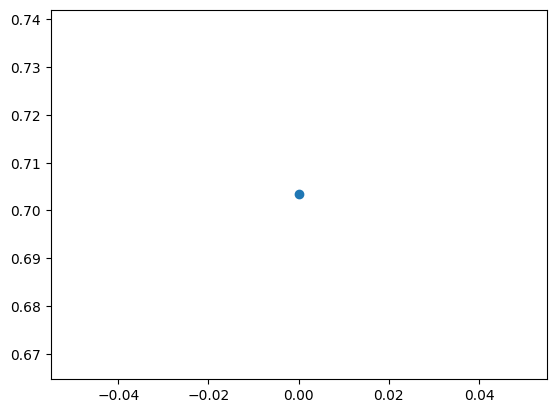

In [ ]:
import matplotlib.pyplot as plt
print(loss)
plt.plot(list(range(1)), loss[1:],linestyle="",marker="o")


In [ ]:
accs20241028 = acclst

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore error 'model' is not defined

torch.cuda.empty_cache()
gc.collect()
#!nvidia-smi #prints out stats

del model

## Result Analysis

In [ ]:
# @title TwinTransformerGetBadResults Definition
def TwinTransformerGetBadResults(model, dTest, lTest, batchsize=64):
    '''
    Test the TwinRNN model.
    :param model: deep learning model.
    :param dTest: test data.
    :param lTest: test label.
    :param batchsize: number of samples in a batch
    :return: predictions - predicted labels. [[0], [1], ...]
             accuracy - the total test accuracy. numeric
    '''

    # tensor data processing.
    xTest = torch.from_numpy(dTest).long().to(device)
    yTest = torch.from_numpy(lTest).long().to(device)

    # batch size processing.
    test = torchdata.TensorDataset(xTest, yTest)
    testloader = torchdata.DataLoader(test, batch_size=1, shuffle=False)

    # load the model of recurrent neural network.
    model.to(device)

    # testing phase.
    model.eval()
    predictions = []
    labels = []
    falsePositives = []
    falseNegatives = []
    with torch.no_grad():
        for iter, (data, label) in enumerate(testloader):
            # data conversion.
            data = data.to(device)
            label = label.contiguous().view(-1)
            label = label.to(device)
            # forward propagation.
            yhat = model.forward(data)  # get output
            # statistic
            preds = torch.argmax(torch.softmax(yhat,dim=1),dim=1)
            if preds[0].int() != label.int():
              if preds[0].int() == 1:
                falsePositives.append(data)
              if preds[0].int() == 0:
                falseNegatives.append(data)

            predictions.extend(preds.int().tolist())
            labels.extend(label.int().tolist())
            torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.empty_cache()

    # testing accuracy.
    accuracy = accuracy_score(labels, predictions) * 100
    predictions = [[item] for item in predictions]

    return predictions, accuracy, falsePositives, falseNegatives

In [ ]:
model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))



<ipython-input-49-a8faf42b97f2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


<All keys matched successfully>

In [ ]:
p,a,fp,fn = TwinTransformerGetBadResults(model,dataTest,labelTest)

In [ ]:
_, confusion = OutputEval(p, labelTest, 'TwinTwinTransformer')

       -------------------------------------------
       method           :  TwinTwinTransformer
       accuracy  (ACC)  :  83.333%
       precision (P)    :  76.322%
       recall    (R)    :  70.037%
       F1 score  (F1)   :  0.730
       fall-out  (FPR)  :  10.339%
       miss rate (FNR)  :  29.963%
       confusion matrix :      (actual)
                           Neg         Pos
       (predicted) Neg     4622 (TN)   735  (FN)
                   Pos     533  (FP)   1718 (TP)
       -------------------------------------------


In [ ]:
fdata = np.concatenate((fp,fn)).squeeze()
flabels = np.concatenate((np.zeros((len(fp),1)),np.ones((len(fn),1))))
fdata.shape

(1268, 800, 13)

In [ ]:
  modelV, acc = TwinTransformerTrain(fdata, flabels, dataTest, labelTest, preWTwin=twinPreWeights, preWMsg=msgPreWeights,
                            batchsize=_TRnnBatchSz_, learnRate=_TRnnLearnRt_, dTest=dataTest, lTest=labelTest)
  acclst = acc
  # TwinRNNTest
  predictions, accuracy = TwinTransformerTest(model, dataTest, labelTest, batchsize=_TRnnBatchSz_)
  _, confusion = OutputEval(predictions, labelTest, 'TwinTwinTransformerV')

[INFO] <TwinTransformer> ModelType: TwinTransformer.
[Epoch 001] loss: 3.32, train acc: 28.391%, valid acc: 67.758%, test acc: 67.758%.
[Epoch 002] loss: 0.324, train acc: 91.719%, valid acc: 32.242%, test acc: 32.242%.


KeyboardInterrupt: 

In [ ]:
def TransformPatch2Imgs(sequence): #sequence 800x5
  bf = sequence[:,0:5]
  b = np.zeros((800,5))
  for i in range(len(bf)):
    itemValue = bf[i][0]
    itemChannel = np.argmax(bf[i][1:6])
    b[i][itemChannel] = itemValue
  b = b.reshape((20,40,5))
  af = sequence[:,6:]
  a = np.zeros((800,5))
  for i in range(len(af)):
    itemValue = af[i][0]
    itemChannel = np.argmax(af[i][1:6])
    a[i][itemChannel] = itemValue
  a = a.reshape((20,40,5))

  c = np.zeros((40,40,5))
  iter = 0
  for i in range(0,20):
    c[iter]=b[i]
    c[iter+1]=a[i]
    iter = iter +2

  return b,a,c #20x40x5 #h,w,c


In [ ]:
before, after, concatenated = TransformPatch2Imgs(fp[0])


# Analysis

In [ ]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


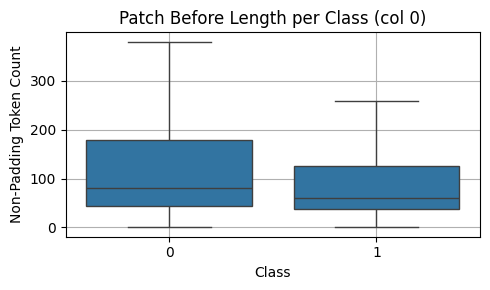

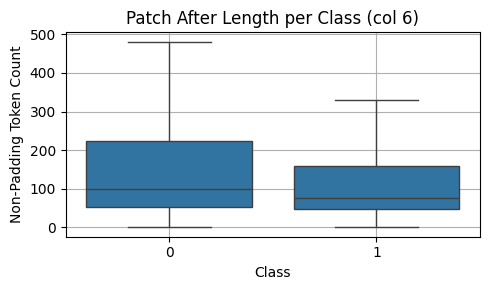

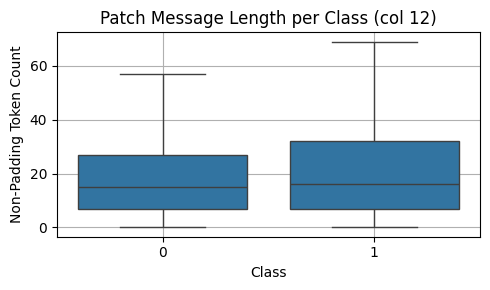

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def compute_sequence_lengths_3seq(data):
    # Extract token sequences from columns 0, 6, 12
    seq1 = data[:, :, 0]
    seq2 = data[:, :, 6]
    seq3 = data[:, :, 12]

    # Count non-zero (non-pad) tokens in each sequence
    len1 = np.count_nonzero(seq1, axis=1)
    len2 = np.count_nonzero(seq2, axis=1)
    len3 = np.count_nonzero(seq3, axis=1)

    return len1, len2, len3

def plot_length_by_class(lengths, labels, title='', filename=None):
    df = pd.DataFrame({
        'Length': lengths,
        'Class': labels
    })

    plt.figure(figsize=(5, 3))
    sns.boxplot(x='Class', y='Length', data=df, showfliers=False)
    # Removed stripplot (no circles)
    plt.title(title or 'Sequence Length Distribution per Class')
    plt.xlabel('Class')
    plt.ylabel('Non-Padding Token Count')
    plt.grid(True)
    plt.tight_layout()
    if filename!=None:
      plt.savefig(filename)
    plt.show()


# Compute lengths
len1, len2, len3 = compute_sequence_lengths_3seq(dataTrain)
labels_flat = np.asarray(labelTrain).flatten()

# Plot each sequence separately
plot_length_by_class(len1, labels_flat, title='Patch Before Length per Class (col 0)',filename='plots/seqBlpc.png')
plot_length_by_class(len2, labels_flat, title='Patch After Length per Class (col 6)',filename='plots/seqAlpc.png')
plot_length_by_class(len3, labels_flat, title='Patch Message Length per Class (col 12)',filename='plots/seqMlpc.png')


In [ ]:
def print_sequence_length_stats(len1, len2, len3, labels):
    seq_names = ['Patch Before (col 0)', 'Patch After (col 6)', 'Patch Message (col 12)']
    all_lengths = [len1, len2, len3]

    for i, (name, lengths) in enumerate(zip(seq_names, all_lengths), 1):
        print(f"\nSequence {i}: {name}")
        print("Overall Stats:")
        print(f"  Min:    {lengths.min()}")
        print(f"  Max:    {lengths.max()}")
        print(f"  Mean:   {lengths.mean():.2f}")
        print(f"  Median: {np.median(lengths)}")
        print(f"  Std:    {lengths.std():.2f}")

        print("\nStats Per Class:")
        unique_classes = np.unique(labels)
        for cls in unique_classes:
            cls_lengths = lengths[labels == cls]
            print(f"  Class {cls}:")
            print(f"    Count:  {len(cls_lengths)}")
            print(f"    Min:    {cls_lengths.min()}")
            print(f"    Max:    {cls_lengths.max()}")
            print(f"    Mean:   {cls_lengths.mean():.2f}")
            print(f"    Median: {np.median(cls_lengths)}")
            print(f"    Std:    {cls_lengths.std():.2f}")
        print("-" * 50)


In [ ]:
print_sequence_length_stats(len1, len2, len3, labels_flat)


Sequence 1: Patch Before (col 0)
Overall Stats:
  Min:    0
  Max:    800
  Mean:   147.78
  Median: 72.0
  Std:    186.96

Stats Per Class:
  Class 0:
    Count:  20442
    Min:    0
    Max:    800
    Mean:   159.19
    Median: 80.0
    Std:    194.66
  Class 1:
    Count:  9991
    Min:    0
    Max:    800
    Mean:   124.45
    Median: 61.0
    Std:    167.71
--------------------------------------------------

Sequence 2: Patch After (col 6)
Overall Stats:
  Min:    0
  Max:    800
  Mean:   178.14
  Median: 91.0
  Std:    205.21

Stats Per Class:
  Class 0:
    Count:  20442
    Min:    0
    Max:    800
    Mean:   190.58
    Median: 100.0
    Std:    212.04
  Class 1:
    Count:  9991
    Min:    0
    Max:    800
    Mean:   152.70
    Median: 76.0
    Std:    187.91
--------------------------------------------------

Sequence 3: Patch Message (col 12)
Overall Stats:
  Min:    0
  Max:    200
  Mean:   24.33
  Median: 15.0
  Std:    30.09

Stats Per Class:
  Class 0:
    Cou

## Model load

In [166]:
model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
model


<ipython-input-166-a280eb0d4e3d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))


TwinTransformer(
  (embedTwin): Embedding(35576, 128)
  (embedMsg): Embedding(80831, 128)
  (transformerTwinB): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformerTwinA): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAt

In [ ]:
# Reshape your entire dataset
X_train_flat = dataTrain.reshape(dataTrain.shape[0], -1)  # shape = (N, 10400)
X_test_flat = dataTest.reshape(dataTest.shape[0], -1)


In [269]:
model.eval()


TwinTransformer(
  (embedTwin): Embedding(35576, 128)
  (embedMsg): Embedding(80831, 128)
  (transformerTwinB): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformerTwinA): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAt

In [ ]:
X_train_flat.shape

(30433, 10400)

In [168]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwinWrapper(nn.Module):
    def __init__(self, model, twin_max_len, msg_max_len):
        """
        Wrapper for TwinCNN to accept three separate ID sequences.
        :param model: the original TwinCNN model
        :param twin_max_len: maximum length of twin sequences
        :param msg_max_len: maximum length of msg sequence
        """
        super(TwinWrapper, self).__init__()
        self.model = model
        self.twin_max_len = twin_max_len
        self.msg_max_len = msg_max_len

    def forward(self, twin_b_ids, twin_b_cls, twin_a_ids, twin_a_cls, msg_ids):
        """
        :param twin_b_ids: Tensor of shape (batch_size, twin_max_len)
        :param twin_a_ids: Tensor of shape (batch_size, twin_max_len)
        :param msg_ids: Tensor of shape (batch_size, msg_max_len)
        :return: probabilities of shape (batch_size, 2)
        """
        batch_size = twin_b_ids.size(0)

        # Rebuild the original input tensor structure
        # Twin B: (batch, twin_max_len, 1) — first column (index 0) placeholder
        xTwinB = torch.zeros((batch_size, self.twin_max_len, 6), dtype=torch.long, device=twin_b_ids.device)
        xTwinB[:, :, 0] = twin_b_ids  # store ids in first column
        xTwinB[:, :, 1:6] = twin_b_cls.reshape((-1, 800, 5))

        # Twin A: (batch, twin_max_len, 1) — index 0 again
        xTwinA = torch.zeros((batch_size, self.twin_max_len, 6), dtype=torch.long, device=twin_a_ids.device)
        xTwinA[:, :, 0] = twin_a_ids
        xTwinA[:, :, 1:6] = twin_a_cls.reshape((-1, 800, 5))

        # Msg: (batch, msg_max_len, 1) — a single column
        xMsg = torch.zeros((batch_size, self.msg_max_len, 1), dtype=torch.long, device=msg_ids.device)
        xMsg[:, :, 0] = msg_ids

        # Concatenate everything into shape: (batch_size, max_len, feature_dim)
        x = torch.cat([
            torch.cat([xTwinB, xTwinA], dim=2),  # shape: (batch, twin_max_len, 12)
            xMsg                                 # shape: (batch, msg_max_len, 1)
        ], dim=2)  # result: (batch, total_seq_len, 13)

        # Run through the original model
        logits = self.model(x)

        # Apply softmax to get probabilities
        probs = F.softmax(logits, dim=1)

        return probs


In [270]:
wrapper = TwinWrapper(model, twin_max_len=_TwinMaxLen_, msg_max_len=_TwinMaxLen_)
wrapper.eval()

TwinWrapper(
  (model): TwinTransformer(
    (embedTwin): Embedding(35576, 128)
    (embedMsg): Embedding(80831, 128)
    (transformerTwinB): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (transformerTwinA): TransformerEncoder(
      (layers): ModuleList(
  

In [ ]:
labelTest[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0]])

In [ ]:
for i in range(len(dataTest)):
  if(dataTest[i][12][0]==0):
    print(i)
    print(labelTest[i])
    print('___')

173
[0]
___
186
[0]
___
705
[0]
___
784
[0]
___
800
[0]
___
891
[1]
___
987
[0]
___
1052
[0]
___
1177
[0]
___
1423
[0]
___
1494
[1]
___
1555
[0]
___
1583
[1]
___
1740
[1]
___
1846
[0]
___
1969
[1]
___
2344
[1]
___
2600
[0]
___
2634
[1]
___
3251
[0]
___
3391
[0]
___
3540
[0]
___
3910
[1]
___
3993
[1]
___
4053
[0]
___
4062
[0]
___
4262
[1]
___
4266
[0]
___
4805
[0]
___
4835
[0]
___
5328
[0]
___
5358
[0]
___
5371
[0]
___
5486
[0]
___
5744
[0]
___
5853
[0]
___
6009
[1]
___
6037
[0]
___
6080
[0]
___
6101
[0]
___
6130
[0]
___
6167
[0]
___
6227
[1]
___
6265
[0]
___
6319
[0]
___
6513
[0]
___
6570
[1]
___
6674
[1]
___
6799
[0]
___
6813
[1]
___
6818
[0]
___


In [ ]:
#@title Notes
# Indexing from 0
# Test Item 7 classified as 1 real is 1
# Test Item 8 classified as 0 real is 1
# Test Item 173 classified as 0 real is 0
# Test Item 784 classified as 1 real is 0
# Test Item 1494 classified as 0 real is 1
# Test Item 1583 classified as 1 real is 1

In [ ]:
dataTest[10][:,12]

array([  532,  6247, 55258,   213,  1742,  3025,   121,   452,   156,
        1783,  2866,  1742,   188,   156,    79,  3025,  1401,    65,
         452,   213,   342,  6047,  2818,   312,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

### LIME

In [170]:
#@title Pick a sample
analyzedSampleIdx = 7
eX = dataTest[analyzedSampleIdx].copy()
eXflat = np.array([X_test_flat[analyzedSampleIdx]])
eXflat_full = X_test_flat
eXlabel = labelTest[analyzedSampleIdx][0]

In [171]:
!pip install lime

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer
import numpy as np
import torch

seq_len = 800
feature_dim = 13
twin_len = seq_len
msg_len = 800

# TwinCNNWrapper is already instantiated as `wrapper`
wrapper.eval()

# Utility: Get index positions
def get_indices(col_idx):
    return np.arange(col_idx, seq_len * feature_dim, feature_dim)

# Get indices of token types
twin_b_indices = get_indices(0)
twin_b_cls_indices =  np.concatenate([get_indices(1), get_indices(2), get_indices(3), get_indices(4), get_indices(5)])
twin_a_indices = get_indices(6)
twin_a_cls_indices =  np.concatenate([get_indices(7), get_indices(8), get_indices(9), get_indices(10), get_indices(11)])
msg_indices     = get_indices(12)  # trim msg to 200

### LIME TEXT

In [172]:
diff_dict = GetDiffDict(diffVocab)
msg_diff_dict = GetMsgDict(msgVocab)

[INFO] <GetDiffDict> Create dictionary for 35576 diff vocabulary tokens. (with '<pad>')
[INFO] <GetMsgDict> Create dictionary for 80831 msg vocabulary tokens. (with '<pad>')


In [173]:
def decode(seq,diffDict):
  x = []
  def find(dic,val):
    for k,v in diffDict.items():
      if(v == val):
        return k
    return None
  for item in seq:
    x.append(find(diffDict,item))
  return x
def decodeMsg(seq,msgdiffDict):
  x = []
  def find(dic,val):
    for k,v in msgdiffDict.items():
      if(v == val):
        return k
    return None
  for item in seq:
    x.append(find(msgdiffDict,item))
  return x
def encode(seq,diffDict):
  x = []
  for item in seq:
      x.append(diffDict.get(item, diffDict.get('<unk>', 0)))  # default to <unk> or 0
  return x
def encodeMsg(seq,msgdiffDict):
  x = []
  for item in seq:
      x.append(msgdiffDict.get(item, msgdiffDict.get('<unk>', 0)))  # default to <unk> or 0
  return x


In [174]:
_space_ = '\u202F'

has_char = any(_space_ in key for key in msg_diff_dict.keys())

print(has_char)
print(len(_space_))

has_char = any(_space_ in key for key in diff_dict.keys())

print(has_char)

False
1
False


In [175]:
_joiner_ = '\r'
has_char = any(_joiner_ in key for key in msg_diff_dict.keys())

print(has_char)
print(len(_joiner_))

has_char = any(_joiner_ in key for key in diff_dict.keys())

print(has_char)

False
1
False


In [176]:
#@title def save_lime_explanation_plot
!mkdir plots
# Get the figure
import matplotlib.pyplot as plt
import os
os.makedirs("plots", exist_ok=True)

def save_lime_explanation_plot(explanation, subtitle, filename):
    fig = explanation.as_pyplot_figure()
    fig.set_size_inches(10, 6)

    ax = fig.gca()
    ax.set_title(f'LIME Explanation - Top Features\n{subtitle}', fontsize=16, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=12)

    fig.tight_layout()
    xmin, xmax = ax.get_xlim()
    offset = 0.01 * (xmax - xmin)  # small nudge for text spacing

    for bar in ax.patches:
        width = bar.get_width()
        ypos = bar.get_y() + bar.get_height() / 2

        # Set color based on value
        if width > 0:
            bar.set_color('#2ca02c')  # green
            xpos = 0 + offset  # just to the right of zero
            align = 'left'
        else:
            bar.set_color('#d62728')  # red
            xpos = 0 - offset  # just to the left of zero
            align = 'right'

        ax.text(xpos, ypos, f'{width:.5f}', va='center', ha=align, fontsize=11, color='white')

    fig.tight_layout()
    fig.savefig(filename, dpi=300)
    plt.close(fig)


#fig.savefig('plots/lime_explanation-msg.png', dpi=300, bbox_inches='tight')

mkdir: cannot create directory ‘plots’: File exists


In [177]:
#@title Msg

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinB_cls = eXflat[0][twin_b_cls_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_twinA_cls = eXflat[0][twin_a_cls_indices].astype(int)

# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []

    for text in text_list:
        tokens = encodeMsg(text.split(_space_),msg_diff_dict)
        tokens = tokens[:msg_len] + [0] * (msg_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.tensor(predict_proba_from_text_twinB).long()
        twin_b_cls = torch.tensor(predict_proba_from_text_twinB_cls).long()
        twin_a = torch.tensor(predict_proba_from_text_twinA).long()
        twin_a_cls = torch.tensor(predict_proba_from_text_twinA_cls).long()

        all_twin_b.append(twin_b)
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(twin_a)
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(torch.tensor(tokens).long())

    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()

# Example instance to explain
original_text = _space_.join(decodeMsg(eXflat[0][msg_indices].astype(int),msg_diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [178]:
save_lime_explanation_plot(explanation,
                           f'Message Sequence \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-msg.png')

In [ ]:
from IPython.display import HTML

# explanation.as_list() returns list of (feature, weight) tuples
features = explanation.as_list()

# original text split into words
words = original_text.split()

# Build HTML with highlights: red for negative, green for positive weights
highlighted_text = []
for word in words:
    # Find matching feature weight (simplified: check if word in feature)
    weight = next((w for f, w in features if word in f), 0)
    color = 'rgba(0, 255, 0, 0.4)' if weight > 0 else 'rgba(255, 0, 0, 0.4)' if weight < 0 else 'transparent'
    highlighted_text.append(f'<span style="background-color:{color}">{word}</span>')

html = ' '.join(highlighted_text)
display(HTML(html))


In [179]:
#@title Msg-0-0

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinB_cls = eXflat[0][twin_b_cls_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_twinA_cls = eXflat[0][twin_a_cls_indices].astype(int)

# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []


    for text in text_list:
        tokens = encodeMsg(text.split(_space_),msg_diff_dict)
        tokens = tokens[:msg_len] + [0] * (msg_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.zeros(predict_proba_from_text_twinB.shape).long()
        twin_b_cls = torch.zeros(predict_proba_from_text_twinB_cls.shape).long()
        twin_a = torch.zeros(predict_proba_from_text_twinA.shape).long()
        twin_a_cls = torch.zeros(predict_proba_from_text_twinA_cls.shape).long()

        all_twin_b.append(twin_b)
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(twin_a)
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(torch.tensor(tokens).long())

    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()

# Example instance to explain
original_text = _space_.join(decodeMsg(eXflat[0][msg_indices].astype(int),msg_diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [180]:
save_lime_explanation_plot(explanation,
                           f'Message Sequence (Standalone) \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-msg-0-0.png')

In [181]:
#@title TwinB

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinB_cls = eXflat[0][twin_b_cls_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_twinA_cls = eXflat[0][twin_a_cls_indices].astype(int)
predict_proba_from_text_msg = eXflat[0][msg_indices].astype(int)

# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []

    for text in text_list:
        tokens = encode(text.split(_space_),diff_dict)
        tokens = tokens[:twin_len] + [0] * (twin_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.tensor(predict_proba_from_text_twinB).long()
        twin_b_cls = torch.tensor(predict_proba_from_text_twinB_cls).long()
        twin_a = torch.tensor(predict_proba_from_text_twinA).long()
        twin_a_cls = torch.tensor(predict_proba_from_text_twinA_cls).long()
        twin_msg = torch.tensor(predict_proba_from_text_msg).long()

        all_twin_b.append(torch.tensor(tokens).long())
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(twin_a)
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(twin_msg)

    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()

# Example instance to explain
original_text = _space_.join(decode(eXflat[0][twin_b_indices].astype(int),diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [182]:
save_lime_explanation_plot(explanation,
                           f'Commit Before Sequence \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-cbp.png')

In [183]:
#@title TwinB-0-0

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinB_cls = eXflat[0][twin_b_cls_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_twinA_cls = eXflat[0][twin_a_cls_indices].astype(int)
predict_proba_from_text_msg = eXflat[0][msg_indices].astype(int)

# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []


    for text in text_list:
        tokens = encode(text.split(_space_),diff_dict)
        tokens = tokens[:twin_len] + [0] * (twin_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.zeros(predict_proba_from_text_twinB.shape).long()
        twin_b_cls = torch.zeros(predict_proba_from_text_twinB_cls.shape).long()
        twin_a = torch.zeros(predict_proba_from_text_twinA.shape).long()
        twin_a_cls = torch.zeros(predict_proba_from_text_twinA_cls.shape).long()
        twin_msg = torch.zeros(predict_proba_from_text_msg.shape).long()

        all_twin_b.append(torch.tensor(tokens).long())
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(twin_a)
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(twin_msg)

    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()

# Example instance to explain
original_text = _space_.join(decode(eXflat[0][twin_b_indices].astype(int),diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [184]:
save_lime_explanation_plot(explanation,
                           f'Commit Before Sequence (Standalone) \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-cbp-0-0.png')

In [185]:
#@title TwinA

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinB_cls = eXflat[0][twin_b_cls_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_twinA_cls = eXflat[0][twin_a_cls_indices].astype(int)
predict_proba_from_text_msg = eXflat[0][msg_indices].astype(int)


# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []

    for text in text_list:
        tokens = encode(text.split(_space_),diff_dict)
        tokens = tokens[:twin_len] + [0] * (twin_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.tensor(predict_proba_from_text_twinB).long()
        twin_b_cls = torch.tensor(predict_proba_from_text_twinB_cls).long()
        twin_a = torch.tensor(predict_proba_from_text_twinA).long()
        twin_a_cls = torch.tensor(predict_proba_from_text_twinA_cls).long()
        twin_msg = torch.tensor(predict_proba_from_text_msg).long()

        all_twin_b.append(twin_b)
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(torch.tensor(tokens).long())
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(twin_msg)


    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()
# Example instance to explain
original_text = _space_.join(decode(eXflat[0][twin_a_indices].astype(int),diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [186]:
save_lime_explanation_plot(explanation,
                           f'Commit After Sequence \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-cap.png')

In [187]:
#@title TwinA-0-0

from lime.lime_text import LimeTextExplainer
from transformers import AutoTokenizer
import numpy as np
import torch

predict_proba_from_text_twinB = eXflat[0][twin_b_indices].astype(int)
predict_proba_from_text_twinA = eXflat[0][twin_a_indices].astype(int)
predict_proba_from_text_msg = eXflat[0][msg_indices].astype(int)

# Define text-based prediction wrapper
def predict_proba_from_text(text_list):
    all_twin_b = []
    all_twin_b_cls = []
    all_twin_a = []
    all_twin_a_cls = []
    all_msg = []

    for text in text_list:
        tokens = encode(text.split(_space_),diff_dict)
        tokens = tokens[:twin_len] + [0] * (twin_len - len(tokens))  # Ensure fixed length

        # Fill twin A/B with dummy or reference IDs if needed
        twin_b = torch.zeros(predict_proba_from_text_twinB.shape).long()
        twin_b_cls = torch.zeros(predict_proba_from_text_twinB_cls.shape).long()
        twin_a = torch.zeros(predict_proba_from_text_twinA.shape).long()
        twin_a_cls = torch.zeros(predict_proba_from_text_twinA_cls.shape).long()
        twin_msg = torch.zeros(predict_proba_from_text_msg.shape).long()

        all_twin_b.append(twin_b)
        all_twin_b_cls.append(twin_b_cls)
        all_twin_a.append(torch.tensor(tokens).long())
        all_twin_a_cls.append(twin_a_cls)
        all_msg.append(twin_msg)

    twin_b_tensor = torch.stack(all_twin_b)
    twin_b_cls_tensor = torch.stack(all_twin_b_cls)
    twin_a_tensor = torch.stack(all_twin_a)
    twin_a_cls_tensor = torch.stack(all_twin_a_cls)
    msg_tensor    = torch.stack(all_msg)

    with torch.no_grad():
        probs = wrapper(twin_b_tensor, twin_b_cls_tensor, twin_a_tensor, twin_a_cls_tensor, msg_tensor)
    return probs.cpu().numpy()
# Example instance to explain
original_text = _space_.join(decode(eXflat[0][twin_a_indices].astype(int),diff_dict))

explainer = LimeTextExplainer(class_names=['Non-Security Patch', 'Security Patch'],random_state=42)  # Adjust class names as needed

explanation = explainer.explain_instance(
    original_text,
    predict_proba_from_text,
    num_features=10,
    num_samples=10400
)
#explanation.show_in_notebook()

In [188]:
save_lime_explanation_plot(explanation,
                           f'Commit After Sequence (Standalone) \n Sample {analyzedSampleIdx+1} (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})'
                           ,'plots/lime_explanation-cap-0-0.png')

### SHAP

In [347]:
#@title Pick a sample
analyzedSampleIdx = 7
eX = dataTest[analyzedSampleIdx].copy()
eXflat = np.array([X_test_flat[analyzedSampleIdx]])
eXflat_full = X_train_flat #THIS has to be train! (for background in SHAP)
eXlabel = labelTest[analyzedSampleIdx][0]

In [ ]:
!pip install shap

In [288]:
import shap
import numpy as np
import torch

# Assuming you have:
# - `wrapper` as your original trained model (Torch nn.Module)
# - `TwinWrapper` class from your code (wraps your model to accept separated sequences)
# - eXflat: your single flattened test instance as numpy array shape (1, 10400)
# - seq_len=800, feature_dim=13

# Instantiate the wrapped model (if not done yet)
twin_max_len = 800
msg_max_len = 800
wrapped_model = TwinWrapper(model, twin_max_len, msg_max_len)
wrapped_model.eval()

# Define a function that SHAP can call, which accepts 2D numpy array (batch, features)
def shap_predict(input_array):
    """
    input_array: np.array of shape (batch_size, seq_len * feature_dim) e.g. (N, 10400)
    Returns: np.array of shape (batch_size, num_classes) with probabilities
    """
    input_array = np.array(input_array)
    batch_size = input_array.shape[0]
    # Reshape input to (batch_size, seq_len, feature_dim)
    reshaped = input_array.reshape(batch_size, twin_max_len, feature_dim)

    # Extract twin_b, twin_a, msg from their respective columns
    twin_b_ids = torch.tensor(reshaped[:, :, 0], dtype=torch.long)
    twin_b_cls = torch.zeros(reshaped[:, :, 1:6].shape, dtype=torch.long)
    twin_a_ids = torch.tensor(reshaped[:, :, 6], dtype=torch.long)
    twin_a_cls = torch.zeros(reshaped[:, :, 7:12].shape, dtype=torch.long)
    msg_ids = torch.tensor(reshaped[:, :, 12], dtype=torch.long)

    with torch.no_grad():
        probs = wrapped_model(twin_b_ids, twin_b_cls, twin_a_ids, twin_b_cls, msg_ids)
    return probs.cpu().numpy()

# Select a background dataset for Kernel SHAP
# Typically, a small subset of training data (e.g., 100 samples)
np.random.seed(42)
background_data = eXflat_full[np.random.choice(len(eXflat_full), 100, replace=False)]

# Create Kernel SHAP explainer
explainer = shap.KernelExplainer(shap_predict, background_data)

# Explain the prediction on your sample (eXflat)
shap_values = explainer.shap_values(eXflat, nsamples=50)  # nsamples controls approximation quality

# shap_values is a list (one array per class), each of shape (1, 10400)

# You can now visualize or analyze shap_values[1] for class 1, etc.


  0%|          | 0/1 [00:00<?, ?it/s]

In [289]:
wrapped_model.model(torch.tensor(dataTrain[0]).unsqueeze(0))

tensor([[ 3.1208, -1.7535]], grad_fn=<AddmmBackward0>)

In [290]:
used_cols = {0, 6, 12}
feature_names = []
for seq in range(seq_len):
    for feat in range(feature_dim):
        if feat in used_cols:
            feature_names.append(f"p{seq}_f{feat}")
        else:
            feature_names.append(f"p{seq}_f{feat}_u")


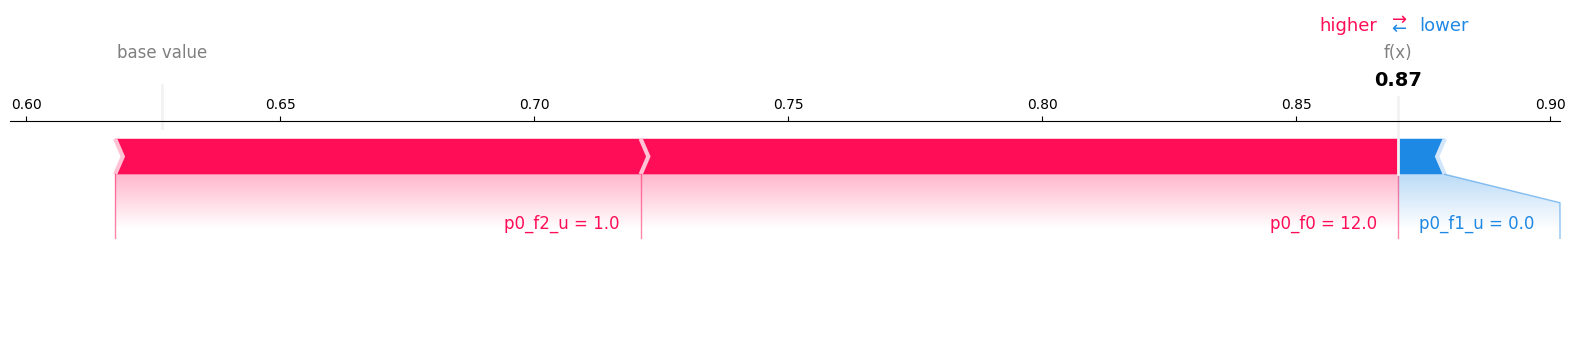

In [291]:
import shap

class_idx = 0

shap.force_plot(
    explainer.expected_value[class_idx],  # expected value per class
    shap_values[0, :, class_idx],          # shap values for first sample, class 1
    eXflat[0],                            # feature values for first sample
    feature_names=feature_names,
    matplotlib=True
)


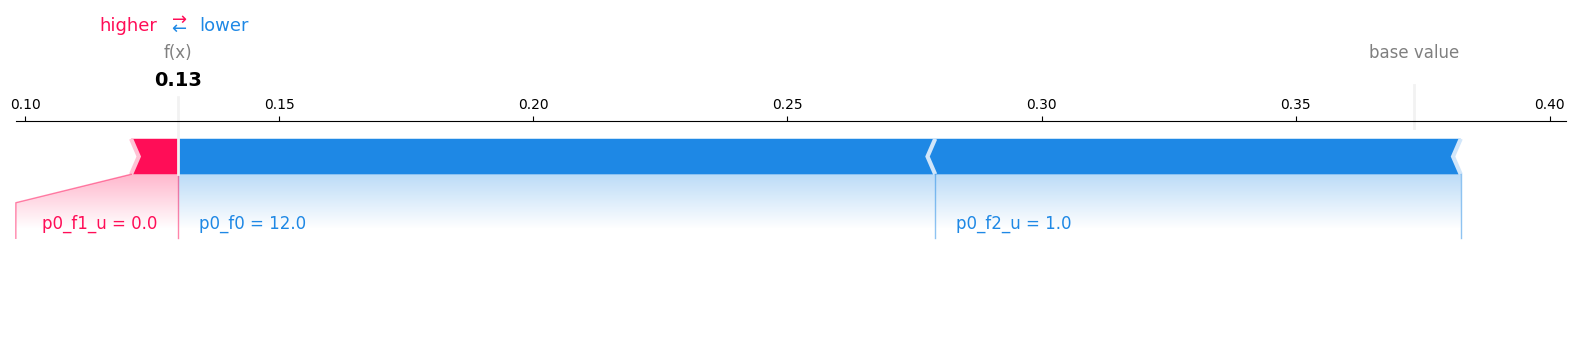

In [292]:
import shap

class_idx = 1

shap.force_plot(
    explainer.expected_value[class_idx],  # expected value per class
    shap_values[0, :, class_idx],          # shap values for first sample, class 1
    eXflat[0],                            # feature values for first sample
    feature_names=feature_names,
    matplotlib=True
)


In [293]:
# shape: (1, 10400, 2)
shap_values.shape


(1, 10400, 2)

In [294]:
shap_class_0 = shap_values[0, :, 0]  # for class 0
shap_class_1 = shap_values[0, :, 1]  # for class 1


In [295]:
shap_values[0, :,:]

array([[ 0.14903787, -0.14903784],
       [-0.00923165,  0.00923164],
       [ 0.10343433, -0.10343431],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [296]:
shap_class_0 = shap_class_0.reshape((800, 13))
shap_class_1 = shap_class_1.reshape((800, 13))

In [297]:
msg_shap_0 = shap_class_0[:, 12]  # shape: (800,)
msg_shap_1 = shap_class_1[:, 12]  # shape: (800,)


In [298]:
msg_tokens = eX[:, 12].astype(int)  # shape: (800,)

In [299]:
decoded_tokens = decodeMsg(msg_tokens,msgDict)

In [ ]:
!pip install imgkit
!sudo apt-get update
!sudo apt-get install wkhtmltopdf

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Fetched 257 kB in 2s (140 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package list

In [300]:
from IPython.display import display, HTML
import numpy as np

# Already defined:
# decoded_tokens, msg_shap_0, msg_shap_1

table_title = f"SHAP | Sample {analyzedSampleIdx+1} CMP | (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})"

diff = np.array(msg_shap_1) - np.array(msg_shap_0)
max_val = np.max(np.abs(diff))
if max_val == 0:
  max_val = 1

norm_diff = diff / max_val
perc_diff = np.abs(norm_diff / np.sum(np.abs(norm_diff)) * 100)

def value_to_color(val):
    if val > 0:
        r = int(255 - 105 * val)
        g = 255
        b = int(255 - 105 * val)
    else:
        r = 255
        g = int(255 + 105 * val)
        b = int(255 + 105 * val)
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    return f"rgb({r},{g},{b})"

rows = ""
pad_shown = False
zero_pad_count = 0

for idx, (token, raw_val, val, valp) in enumerate(zip(decoded_tokens, diff, norm_diff, perc_diff)):
    tk = token if token != "<pad>" else "&lt;pad&gt;"

    if token == "<pad>":
        if pad_shown and raw_val == 0:
            zero_pad_count += 1
            continue
        pad_shown = True

    background = value_to_color(val)
    text_color = "black"

    rows += f"""
        <tr>
            <td style='background-color:{background}; color:{text_color}; padding:4px; text-align:right;'>{idx}</td>
            <td style='background-color:{background}; color:{text_color}; padding:4px; text-align:right;'>{tk}</td>
            <td style='background-color:{background}; color:{text_color}; padding:4px; text-align:right;'>{val:.3f}</td>
            <td style='background-color:{background}; color:{text_color}; padding:4px; text-align:right;'>{valp:.3f}%</td>
        </tr>
    """

if zero_pad_count > 0:
    rows += f"""
        <tr>
            <td colspan="3" style='font-family:monospace; padding:6px; font-style: italic; color: #666; text-align:center;'>
                ... {zero_pad_count} more <code>&lt;pad&gt;</code> tokens with zero importance omitted ...
            </td>
        </tr>
    """

html_output = f"""
<table style='border-collapse: collapse; width: 100%; table-layout: auto;'>
    <thead>
        <tr>
            <th colspan="4"
                style='
                    border-bottom:1px solid #ccc;
                    text-align:center;
                    padding:8px;
                    font-family: Arial, sans-serif;
                    font-size: 1.2em;
                    word-wrap: break-word;
                    white-space: normal;
                    margin: 0 auto;
                '>{table_title}</th>
        </tr>
        <tr>
            <th style='border-bottom:1px solid #ccc; text-align:left; padding:4px;'>Position</th>
            <th style='border-bottom:1px solid #ccc; text-align:left; padding:4px;'>Token</th>
            <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Importance (1 - 0)</th>
            <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Share %</th>
        </tr>
    </thead>
    <tbody>
        {rows}
    </tbody>
</table>
"""

display(HTML(html_output))


<ipython-input-300-8cc156b4e05e>:15: RuntimeWarning: invalid value encountered in divide
  perc_diff = np.abs(norm_diff / np.sum(np.abs(norm_diff)) * 100)


Position,Token,Importance (1 - 0),Share %
0,also,0.000,nan%
1,rais,0.000,nan%
2,chromium,0.000,nan%
3,team,0.000,nan%
4,past,0.000,nan%
5,hit,0.000,nan%
6,convwers,0.000,nan%
7,failur,0.000,nan%
8,switch,0.000,nan%
9,encod,0.000,nan%


In [226]:
max_val

1

In [227]:
import imgkit
!mkdir tmp

options = {
    "format": "png",
    "encoding": "utf-8",
    "quiet": ""
}

# Save your HTML string to a file
with open("tmp/shap_tokens-msg.html", "w") as f:
    f.write(html_output)

# Convert saved HTML file to PNG
imgkit.from_file("tmp/shap_tokens-msg.html", "plots/shap_tokens-msg.png",options=options)


mkdir: cannot create directory ‘tmp’: File exists


True

In [ ]:
print("Min diff:", np.min(diff), "Max diff:", np.max(diff))


Min diff: 0.0 Max diff: 0.22078755570691982


In [228]:
from IPython.display import display, HTML
import numpy as np

# -- Already defined: shap_values, eX, decode, diffDict --

# 1. Reshape SHAP values back to (800, 13)
shap_flat = shap_values[0]  # shape (10400, 2)
shap_class_0 = shap_flat[:, 0].reshape((800, 13))
shap_class_1 = shap_flat[:, 1].reshape((800, 13))

# 2. Select SHAP differences for columns 0 and 6
shap_col0_diff = shap_class_1[:, 0] - shap_class_0[:, 0]
shap_col6_diff = shap_class_1[:, 6] - shap_class_0[:, 6]

# 3. Normalize SHAP differences (robust scaling using max abs)
max_val_b = np.max(np.abs(shap_col0_diff))
if max_val_b == 0:
  max_val_b = 1
max_val_a = np.max(np.abs(shap_col6_diff))
if max_val_a == 0:
  max_val_a = 1

norm_col0 = shap_col0_diff / max_val_a
norm_col6 = shap_col6_diff / max_val_b
val_p_col0 = np.abs(norm_col0 / np.sum(np.abs(norm_col0)) * 100)
if np.max(np.abs(shap_col0_diff)) == 0:
  val_p_col0 = np.zeros(shap_col0_diff.shape)

val_p_col6 = np.abs(norm_col6 / np.sum(np.abs(norm_col6)) * 100)
if np.max(np.abs(shap_col6_diff)) == 0:
  val_p_col6 = np.zeros(shap_col6_diff.shape)

# 4. Decode token IDs
twin_b_ids = eX[:, 0].astype(int)
twin_a_ids = eX[:, 6].astype(int)
tokens_b = decode(twin_b_ids, diffDict)
tokens_a = decode(twin_a_ids, diffDict)

# 5. Color mapping function (red-white-green scale)
def value_to_color(val):
    if val > 0:
        r = int(255 - 105 * val)  # 255 to 150
        g = 255
        b = int(255 - 105 * val)  # 255 to 150
    else:
        r = 255
        g = int(255 + 105 * val)  # 255 to 150
        b = int(255 + 105 * val)  # 255 to 150
    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    return f"rgb({r},{g},{b})"

# 6. Build HTML table for a sequence of tokens and values
def build_colored_table(tokens, values, values_perc, title):
    rows = ""
    pad_shown = False
    pad_skipped = 0

    for idx, (tok, val, valp) in enumerate(zip(tokens, values, values_perc)):
        display_tok = tok if tok != "<pad>" else "&lt;pad&gt;"

        # Padding token logic
        if tok == "<pad>":
            if pad_shown and val == 0:
                pad_skipped += 1
                continue
            pad_shown = True

        background = value_to_color(val)
        rows += f"""
            <tr>
                <td style='background-color:{background}; color:black; padding:4px; text-align:right;'>{idx}</td>
                <td style='background-color:{background}; color:black; padding:4px;'>{display_tok}</td>
                <td title='{val:+.3f}' style='background-color:{background}; color:black; padding:4px; text-align:right;'>{val:.7f}</td>
                <td title='{valp:+.3f}' style='background-color:{background}; color:black; padding:4px; text-align:right;'>{valp:.7f}%</td>
            </tr>
        """

    if pad_skipped > 0:
        rows += f"""
            <tr>
                <td colspan="4" style='font-family:monospace; padding:4px; font-style:italic; color:#666; text-align:center;'>
                    {pad_skipped} more &lt;pad&gt; tokens with zero importance omitted
                </td>
            </tr>
        """

    html = f"""
    <table style='border-collapse: collapse; max-width:500px; word-wrap: break-word; margin-bottom: 16px;'>
        <thead>
            <tr>
                <th colspan="4" style='border-bottom:1px solid #ccc; text-align:center; padding:8px; font-weight:bold; word-wrap:break-word; max-width:600px;'>{title}</th>
            </tr>
            <tr>
                <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Position</th>
                <th style='border-bottom:1px solid #ccc; text-align:left; padding:4px;'>Token</th>
                <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Importance</th>
                <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Share %</th>
            </tr>
        </thead>
        <tbody>
            {rows}
        </tbody>
    </table>
    """
    return html

# 7. Generate and display tables
html_b = build_colored_table(tokens_b, norm_col0, val_p_col0, f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
html_a = build_colored_table(tokens_a, norm_col6, val_p_col6, f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")

display(HTML(html_b))
display(HTML(html_a))


<ipython-input-228-262f272e293f>:25: RuntimeWarning: invalid value encountered in divide
  val_p_col0 = np.abs(norm_col0 / np.sum(np.abs(norm_col0)) * 100)


In [229]:
import imgkit
!mkdir tmp

options = {
    "format": "png",
    "width": 435,          # force the image width
    "disable-smart-width": "",
    "encoding": "utf-8",
    "quiet": ""
}

with open("tmp/shap_tokens-b.html", "w") as f:
    f.write(html_b)

# Convert saved HTML file to PNG
imgkit.from_file("tmp/shap_tokens-b.html", "plots/shap_tokens-b.png", options=options)

with open("tmp/shap_tokens-a.html", "w") as f:
    f.write(html_a)

# Convert saved HTML file to PNG
imgkit.from_file("tmp/shap_tokens-a.html", "plots/shap_tokens-a.png", options=options)

mkdir: cannot create directory ‘tmp’: File exists


True

In [230]:
from IPython.display import display, HTML
import numpy as np

def classToName(classId):
  if(classId == 1):
    return "Keyword"
  elif(classId == 2):
    return "Identifier"
  elif(classId == 3):
    return "Literal"
  elif(classId == 4):
    return "Punctuation"
  elif(classId == 5):
    return "Comment"

def displayHtmlColumn(columnIndex,tokenColumnIndex,tokenClasses,actualClass,title):
  # -- Already defined: shap_values, eX, decode, diffDict --

  # 1. Reshape SHAP values back to (800, 13)
  shap_flat = shap_values[0]  # shape (10400, 2)
  shap_class_0 = shap_flat[:, 0].reshape((800, 13))
  shap_class_1 = shap_flat[:, 1].reshape((800, 13))

  # 2. Select SHAP differences for columns 0 and 6
  shap_col_diff = shap_class_1[:, columnIndex] - shap_class_0[:, columnIndex]

  # 3. Normalize SHAP differences (robust scaling using max abs)
  max_val = np.max(np.abs(shap_col_diff))
  if max_val == 0:
    max_val = 1

  norm_col = shap_col_diff / max_val

  val_p_col = np.abs(norm_col / np.sum(np.abs(norm_col)) * 100)
  if np.max(np.abs(shap_col_diff)) == 0:
    val_p_col = np.zeros(shap_col_diff.shape)

  # 4. Decode token IDs
  twin_ids = eX[:, tokenColumnIndex].astype(int)
  tokens = decode(twin_ids, diffDict)
  classes = eX[:,tokenClasses]

  # 5. Color mapping function (red-white-green scale)
  def value_to_color(val):
      if val > 0:
          r = int(255 - 105 * val)  # 255 to 150
          g = 255
          b = int(255 - 105 * val)  # 255 to 150
      else:
          r = 255
          g = int(255 + 105 * val)  # 255 to 150
          b = int(255 + 105 * val)  # 255 to 150
      r = max(0, min(255, r))
      g = max(0, min(255, g))
      b = max(0, min(255, b))
      return f"rgb({r},{g},{b})"

  # 6. Build HTML table for a sequence of tokens and values
  def build_colored_table(tokens, values, values_perc, title):
      rows = ""
      pad_shown = False
      pad_skipped = 0

      for idx, (tok, val, valp) in enumerate(zip(tokens, values, values_perc)):
          display_tok = tok if tok != "<pad>" else "&lt;pad&gt;"

          # Padding token logic
          if tok == "<pad>":
              if pad_shown and val == 0:
                  pad_skipped += 1
                  continue
              pad_shown = True

          if np.argmax(classes[idx])+1 != actualClass:
            continue

          background = value_to_color(val)
          rows += f"""
              <tr>
                  <td style='background-color:{background}; color:black; padding:4px; text-align:right;'>{idx}</td>
                  <td style='background-color:{background}; color:black; padding:4px;'>{display_tok}</td>
                  <td style='background-color:{background}; color:black; padding:4px;'>{classToName(np.argmax(classes[idx])+1)}({np.argmax(classes[idx])+1})</td>
                  <td title='{val:+.3f}' style='background-color:{background}; color:black; padding:4px; text-align:right;'>{val:.7f}</td>
                  <td title='{valp:+.3f}' style='background-color:{background}; color:black; padding:4px; text-align:right;'>{valp:.7f}%</td>
              </tr>
          """

      if pad_skipped > 0:
          rows += f"""
              <tr>
                  <td colspan="4" style='font-family:monospace; padding:4px; font-style:italic; color:#666; text-align:center;'>
                      {pad_skipped} more &lt;pad&gt; tokens with zero importance omitted
                  </td>
              </tr>
          """

      html = f"""
      <table style='border-collapse: collapse; max-width:500px; word-wrap: break-word; margin-bottom: 16px;'>
          <thead>
              <tr>
                  <th colspan="5" style='border-bottom:1px solid #ccc; text-align:center; padding:8px; font-weight:bold; word-wrap:break-word; max-width:600px;'>{title}</th>
              </tr>
              <tr>
                  <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Position</th>
                  <th style='border-bottom:1px solid #ccc; text-align:left; padding:4px;'>Token</th>
                  <th style='border-bottom:1px solid #ccc; text-align:left; padding:4px;'>Class</th>
                  <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Importance</th>
                  <th style='border-bottom:1px solid #ccc; text-align:right; padding:4px;'>Share %</th>
              </tr>
          </thead>
          <tbody>
              {rows}
          </tbody>
      </table>
      """
      return html

  # 7. Generate and display tables
  html_ = build_colored_table(tokens, norm_col, val_p_col,title)

  display(HTML(html_))
  return html_

hb1 = displayHtmlColumn(columnIndex=1,tokenColumnIndex=0,tokenClasses=[1,2,3,4,5],actualClass=1, title=f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
hb2 = displayHtmlColumn(columnIndex=2,tokenColumnIndex=0,tokenClasses=[1,2,3,4,5],actualClass=2, title=f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
hb3 = displayHtmlColumn(columnIndex=3,tokenColumnIndex=0,tokenClasses=[1,2,3,4,5],actualClass=3, title=f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
hb4 = displayHtmlColumn(columnIndex=4,tokenColumnIndex=0,tokenClasses=[1,2,3,4,5],actualClass=4, title=f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
hb5 = displayHtmlColumn(columnIndex=5,tokenColumnIndex=0,tokenClasses=[1,2,3,4,5],actualClass=5, title=f"SHAP | Sample {analyzedSampleIdx+1} CBP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
ha1 = displayHtmlColumn(columnIndex=7,tokenColumnIndex=6,tokenClasses=[7,8,9,10,11],actualClass=1, title=f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
ha2 = displayHtmlColumn(columnIndex=8,tokenColumnIndex=6,tokenClasses=[7,8,9,10,11],actualClass=2, title=f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
ha3 = displayHtmlColumn(columnIndex=9,tokenColumnIndex=6,tokenClasses=[7,8,9,10,11],actualClass=3, title=f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
ha4 = displayHtmlColumn(columnIndex=10,tokenColumnIndex=6,tokenClasses=[7,8,9,10,11],actualClass=4, title=f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")
ha5 = displayHtmlColumn(columnIndex=11,tokenColumnIndex=6,tokenClasses=[7,8,9,10,11],actualClass=5, title=f"SHAP | Sample {analyzedSampleIdx+1} CAP (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})")

<ipython-input-230-8d31c5b05c30>:34: RuntimeWarning: invalid value encountered in divide
  val_p_col = np.abs(norm_col / np.sum(np.abs(norm_col)) * 100)


In [ ]:
import imgkit
!mkdir tmp

def shapToImg(htmlData,filename):
  options = {
      "format": "png",
      "width": 500,          # force the image width
      "disable-smart-width": "",
      "encoding": "utf-8",
      "quiet": ""
  }

  with open(f"tmp/{filename}.html", "w") as f:
      f.write(htmlData)

  # Convert saved HTML file to PNG
  imgkit.from_file(f"tmp/{filename}.html", f"plots/{filename}.png", options=options)

In [ ]:
shapToImg(hb1,'shap_cls_1b1')
shapToImg(hb2,'shap_cls_2b2')
shapToImg(hb3,'shap_cls_3b3')
shapToImg(hb4,'shap_cls_4b4')
shapToImg(hb5,'shap_cls_5b5')
shapToImg(ha1,'shap_cls_7a1')
shapToImg(ha2,'shap_cls_8a2')
shapToImg(ha3,'shap_cls_9a3')
shapToImg(ha4,'shap_cls_10a4')
shapToImg(ha5,'shap_cls_11a5')

## Classification using sequence length only.

In [ ]:
seqDTr = dataTrain.copy()
seqDTe = dataTest.copy()
seqLTr = labelTrain.copy()
seqLte = labelTest.copy()


In [ ]:
import torch

# Assuming seqLTe is a tensor of labels (0s and 1s)
num_zeros = (seqLTr == 0).sum().item()
num_ones = (seqLTr == 1).sum().item()

total = num_zeros + num_ones

ratio_zeros = num_zeros / total
ratio_ones = num_ones / total

print(f"Number of zeros: {num_zeros}")
print(f"Number of ones: {num_ones}")
print(f"Ratio zeros: {ratio_zeros:.4f}")
print(f"Ratio ones: {ratio_ones:.4f}")


Number of zeros: 20442
Number of ones: 9991
Ratio zeros: 0.6717
Ratio ones: 0.3283


In [ ]:
zero_indices = torch.where(torch.tensor(seqLTr) == 0)[0]
one_indices = torch.where(torch.tensor(seqLTr) == 1)[0]

In [ ]:
print(np.median(seqDTr_lengths[zero_indices][:,0]))
print(np.median(seqDTr_lengths[one_indices][:,0]))

80.0
61.0


In [ ]:
print(np.median(seqDTr_lengths[zero_indices][:,1]))
print(np.median(seqDTr_lengths[one_indices][:,1]))

100.0
76.0


In [ ]:
print(np.median(seqDTr_lengths[zero_indices][:,2]))
print(np.median(seqDTr_lengths[one_indices][:,2]))

15.0
16.0


In [ ]:
import numpy as np

def count_non_padding_tokens(data, cols):
    # data shape: (b, 800, 13)
    b = data.shape[0]
    result = np.zeros((b, len(cols)), dtype=int)

    for i, col in enumerate(cols):
        # Extract the column tokens for all batches: shape (b, 800)
        tokens = data[:, :, col]
        # Count non-zero tokens along the 800 dimension for each batch sample
        counts = np.count_nonzero(tokens != 0, axis=1)
        result[:, i] = counts

    return result

cols_to_check = [0, 6, 12]

seqDTr_lengths = count_non_padding_tokens(seqDTr.values if hasattr(seqDTr, 'values') else seqDTr, cols_to_check)
seqDTe_lengths = count_non_padding_tokens(seqDTe.values if hasattr(seqDTe, 'values') else seqDTe, cols_to_check)


In [ ]:
seqDTr_lengths[:10]

array([[ 57, 154,  23],
       [ 58,  64,   7],
       [ 47,  70,  22],
       [120, 120,  15],
       [ 55,  55,   4],
       [ 66,  96,   9],
       [ 93, 140,   5],
       [719, 800,  20],
       [269, 199,  47],
       [109, 160,  13]])

In [ ]:
def threshold_sweep(X, y, column=2, step=50):
    results = []
    values = X[:, column].squeeze()
    #print(values)
    y = y.squeeze()

    for thresh in range(0, 801, step):
        preds = (values > thresh).astype(int)
        #print(values,preds,y, (preds == y).astype(np.int32))
        correct = (preds == y).astype(np.int32).sum()
        results.append(correct)
    return results


In [ ]:
seqDTr_lengths[:10]

array([[ 57, 154,  23],
       [ 58,  64,   7],
       [ 47,  70,  22],
       [120, 120,  15],
       [ 55,  55,   4],
       [ 66,  96,   9],
       [ 93, 140,   5],
       [719, 800,  20],
       [269, 199,  47],
       [109, 160,  13]])

In [ ]:
seqDTr_lengths.shape,seqLTr.shape

((30433, 3), (30433, 1))

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Given arrays:
# seqDTr_lengths.shape = (30433, 3)
# seqLTr.shape = (30433, 1)

__X = seqDTr_lengths[:, 1].reshape(-1, 1)  # take first column & make it 2D
__y = seqLTr.ravel()                       # flatten labels to shape (30433,)

# Fit logistic regression
__model = LogisticRegression(max_iter=10000)  # increase iterations just in case
__model.fit(__X, __y)

# Predict on test set
__y_pred = __model.predict(__X)

# Evaluate
__acc = accuracy_score(__y, __y_pred)
print(f"Test accuracy: {__acc:.4f}")

# (Optional) Check coefficients
print(f"Coefficients: {__model.coef_}, Intercept: {__model.intercept_}")


Test accuracy: 0.6717
Coefficients: [[-0.00097761]], Intercept: [-0.54933294]


[ 57  58  47 120  55  66  93 719 269 109  64 139  34  59 800  28  31  82
 120  66 100 122  91  67 737  30 246 114 138  62  93  72  52  32  32  10
  60 105  48 800  26  40  42 216 165  55  28  47  77 210  33  94  28  87
 332  28 200  25 429  80 535  47  32 101  41  31  47 132 313  51  95  45
 157  84 650  22 107  60  47 170  28  97 161 421  28  73  59  65 402  31
 624 800  99 800  58  29 374  33 207  44 800  43  33 261  48  37  31 116
  79  72  30 800 114  55 293 270 179   9  45  47  20  75  49 193  51 141
 206  27 800  18  39 158 168 124 184 163 544  54 622  35  36 150  41 362
 214 277 164  60  16 157  94  21 648  65  20 800  73  47  51  60  19  90
 127  45  64 113  23 242  54  24 127  25  76 141 443  73  26 112  47 166
  27  43 128  44  10  45 435 135 800  88 800 350 134  57  74 405  17  67
  32 118  70  99  74  43  42  23  32  47  39  25  52 800  50  49  20  38
  58 368 200  61  20  54  14 115  18  84  32 424 195  26  40  57  50 100
 279  80 800 269 800  83 242 344  79  19  70 213 18

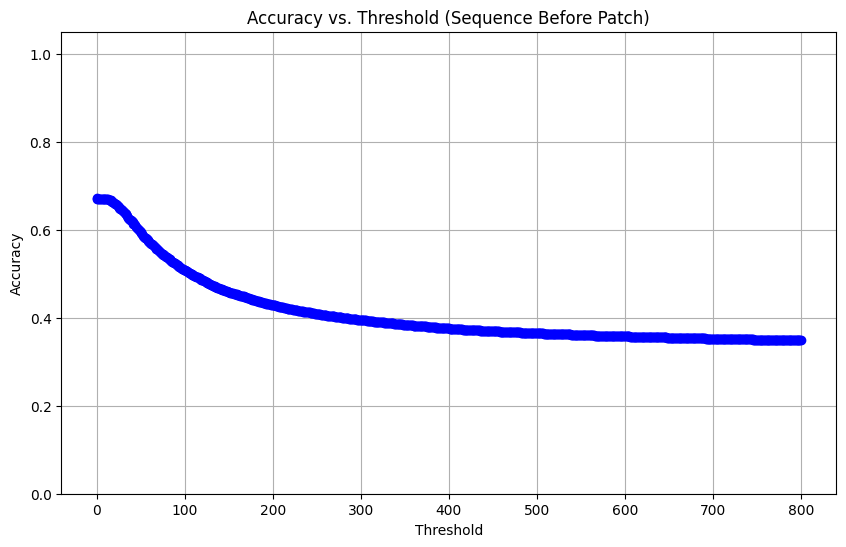

In [ ]:
# Assume:
# seqDTr_lengths: shape (b_train, 2)
# seqLTr: shape (b_train,)
column=0
results = threshold_sweep(seqDTr_lengths, seqLTr, column=column, step=1)
print("Correct predictions at each threshold (0 to 800 step 50):")
print(results)
accs =  torch.tensor(results)/len(seqDTr_lengths)
print(accs,max(accs))
import matplotlib.pyplot as plt
import torch

# Assuming you have:
# accs = torch.tensor(results) / len(seqDTr_lengths)


plt.figure(figsize=(10, 6))
plt.plot(accs, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs. Threshold (Sequence Before Patch)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1.05)
plt.savefig(f"plots/threshold-acc-b.png", dpi=300, bbox_inches='tight')
plt.show()


Correct predictions at each threshold (0 to 800 step 50):
[10005, 10005, 10005, 10005, 10006, 10006, 10006, 10008, 10011, 10011, 10012, 10020, 10024, 10022, 10034, 10042, 10046, 10065, 10095, 10106, 10136, 10143, 10171, 10199, 10230, 10259, 10296, 10331, 10364, 10429, 10475, 10527, 10582, 10626, 10690, 10732, 10780, 10831, 10900, 10940, 10978, 11027, 11066, 11121, 11208, 11260, 11353, 11426, 11486, 11549, 11587, 11654, 11701, 11760, 11820, 11881, 11955, 12034, 12062, 12103, 12175, 12224, 12271, 12334, 12400, 12444, 12507, 12569, 12611, 12663, 12726, 12768, 12815, 12870, 12909, 12967, 13002, 13042, 13106, 13144, 13210, 13255, 13326, 13379, 13449, 13517, 13570, 13626, 13655, 13726, 13779, 13826, 13865, 13890, 13929, 13982, 14017, 14035, 14062, 14106, 14147, 14182, 14213, 14264, 14317, 14353, 14386, 14428, 14473, 14510, 14547, 14594, 14619, 14651, 14687, 14712, 14746, 14786, 14807, 14843, 14882, 14934, 14956, 14991, 15008, 15032, 15067, 15104, 15127, 15145, 15160, 15183, 15215, 15234, 152

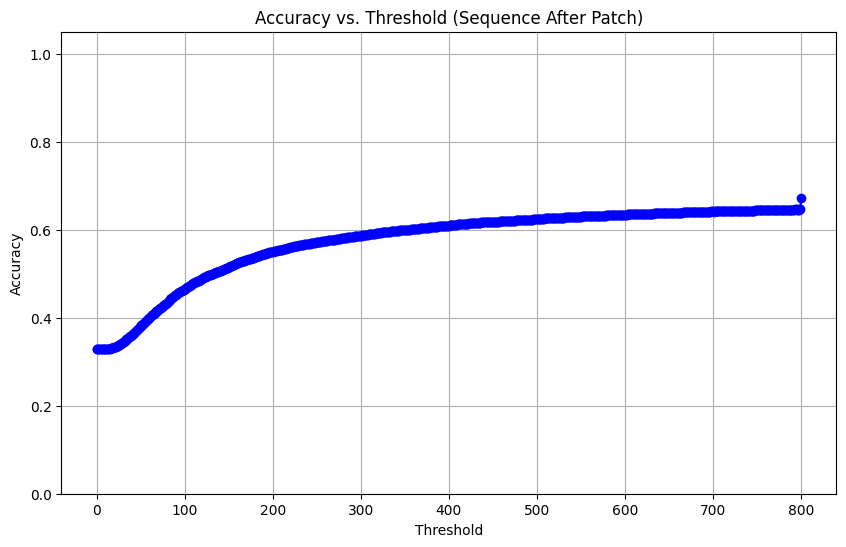

In [ ]:
# Assume:
# seqDTr_lengths: shape (b_train, 2)
# seqLTr: shape (b_train,)
column=1
results = threshold_sweep(seqDTr_lengths, seqLTr, column=column, step=1)
print("Correct predictions at each threshold (0 to 800 step 50):")
print(results)
accs =  torch.tensor(results)/len(seqDTr_lengths)
print(accs,max(accs))
import matplotlib.pyplot as plt
import torch

# Assuming you have:
# accs = torch.tensor(results) / len(seqDTr_lengths)


plt.figure(figsize=(10, 6))
plt.plot(accs, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs. Threshold (Sequence After Patch)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1.05)
plt.savefig(f"plots/threshold-acc-a.png", dpi=300, bbox_inches='tight')
plt.show()


Correct predictions at each threshold (0 to 800 step 50):
[9448, 9412, 9624, 10029, 10647, 11291, 11953, 12538, 13027, 13455, 13915, 14312, 14734, 15107, 15453, 15801, 16112, 16402, 16677, 16946, 17154, 17422, 17631, 17785, 17976, 18132, 18259, 18399, 18554, 18688, 18767, 18863, 18945, 18976, 19106, 19176, 19277, 19371, 19431, 19469, 19522, 19577, 19653, 19706, 19766, 19819, 19862, 19898, 19937, 19981, 20004, 20021, 20050, 20081, 20103, 20141, 20168, 20189, 20190, 20199, 20213, 20230, 20252, 20261, 20263, 20268, 20280, 20290, 20312, 20322, 20337, 20350, 20358, 20353, 20365, 20375, 20382, 20403, 20423, 20426, 20426, 20438, 20449, 20459, 20466, 20471, 20465, 20468, 20472, 20475, 20472, 20475, 20475, 20484, 20494, 20496, 20496, 20497, 20503, 20498, 20502, 20509, 20505, 20510, 20510, 20513, 20510, 20502, 20498, 20505, 20505, 20504, 20502, 20499, 20502, 20504, 20505, 20508, 20506, 20502, 20502, 20505, 20508, 20500, 20487, 20483, 20483, 20485, 20487, 20488, 20491, 20493, 20494, 20493, 20498,

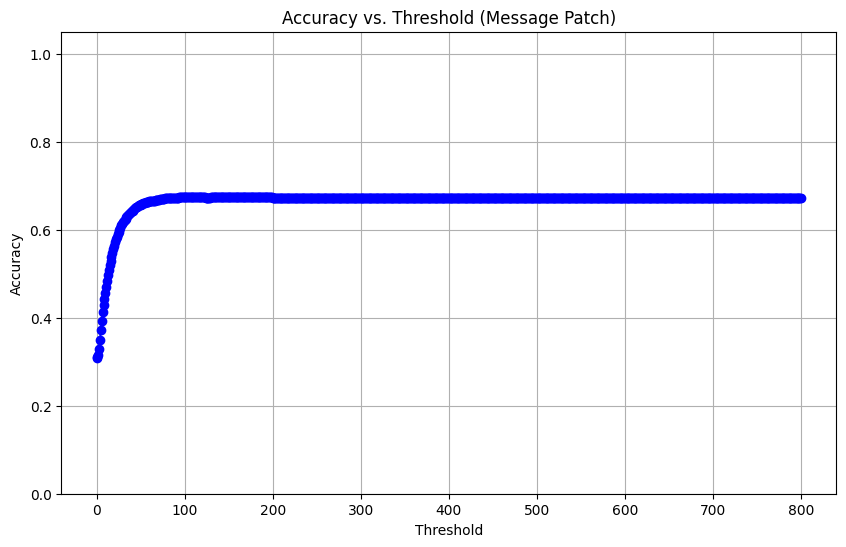

166

In [ ]:
# Assume:
# seqDTr_lengths: shape (b_train, 2)
# seqLTr: shape (b_train,)
column=2
results = threshold_sweep(seqDTr_lengths, seqLTr, column=column, step=1)
print("Correct predictions at each threshold (0 to 800 step 50):")
print(results)
accs =  torch.tensor(results)/len(seqDTr_lengths)
print(accs,max(accs))
import matplotlib.pyplot as plt
import torch

# Assuming you have:
# accs = torch.tensor(results) / len(seqDTr_lengths)


plt.figure(figsize=(10, 6))
plt.plot(accs, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs. Threshold (Message Patch)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1.05)
plt.savefig(f"plots/threshold-acc-msg.png", dpi=300, bbox_inches='tight')
plt.show()

np.argmax(results)

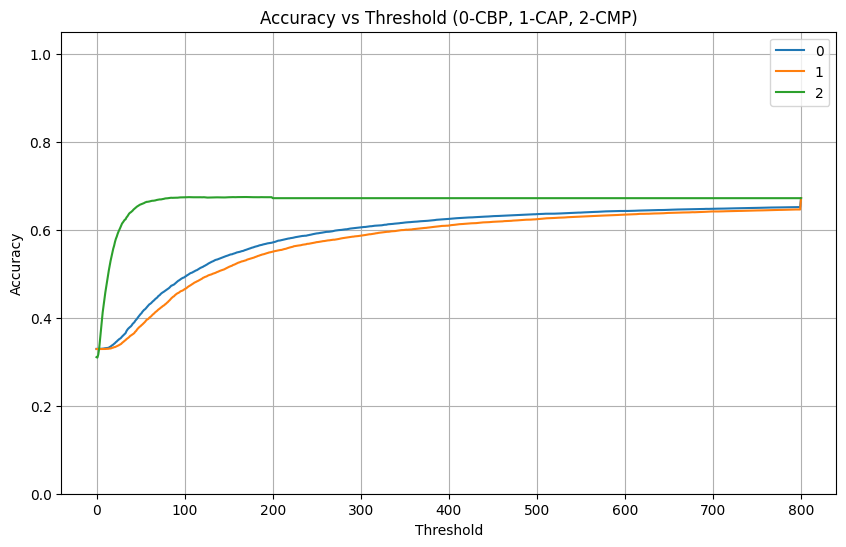

In [ ]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(10, 6))

for col in range(3):
    results = threshold_sweep(seqDTr_lengths, seqLTr, column=col, step=1)
    accs = torch.tensor(results) / len(seqDTr_lengths)
    plt.plot(accs, label=f"{col}")

plt.title("Accuracy vs Threshold (0-CBP, 1-CAP, 2-CMP)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.ylim(0, 1.05)
plt.legend()
plt.savefig("plots/thresholds-acc.png", dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
corr = np.corrcoef(seqDTr_lengths[:,0], seqLTr.squeeze())[0, 1]
print("Pearson correlation:", corr)

Pearson correlation: -0.0872437975020539


In [ ]:
corr = np.corrcoef(seqDTr_lengths[:,1], seqLTr.squeeze())[0, 1]
print("Pearson correlation:", corr)

Pearson correlation: -0.08667193299436272


In [ ]:
corr = np.corrcoef(seqDTr_lengths[:,2], seqLTr.squeeze())[0, 1]
print("Pearson correlation:", corr)

Pearson correlation: 0.08087578320228059


## Integrated Gradients

In [348]:
model = TwinTransformer(None, None, hidSizTwin=_TRnnHidSiz_, hidSizMsg=_MRnnHidSiz_, hidLayTwin=_TRnnHidLay_, hidLayMsg=_MRnnHidLay_,vSizTwin=35576,vSizMsg=80831, emDimTwin=128, emDimMsg=128)
model.load_state_dict(torch.load(tempPath + '/model_TwinTransformer.pth'))
model


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-348-a280eb0d4e3d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.seri

TwinTransformer(
  (embedTwin): Embedding(35576, 128)
  (embedMsg): Embedding(80831, 128)
  (transformerTwinB): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformerTwinA): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAt

In [349]:
model.eval()

TwinTransformer(
  (embedTwin): Embedding(35576, 128)
  (embedMsg): Embedding(80831, 128)
  (transformerTwinB): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformerTwinA): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAt

In [350]:
!pip install captum

In [351]:
from captum.attr import IntegratedGradients

In [352]:
import torch
from captum.attr import IntegratedGradients

# Assume `twin_cnn` is your trained model, and it's in eval mode

# Example input: batch of token IDs (long tensors)
input_tensor = torch.tensor(eX).unsqueeze(0)  # dummy token IDs input

# Extract embeddings for each part from input_tensor
# Split input to parts (assuming _TwinMaxLen_ and _MsgMaxLen_ are defined)
_TwinMaxLen_ = 800
_MsgMaxLen_ = 200

# Embeddings from your embedding layers
embedTwin = model.embedTwin
embedMsg = model.embedMsg

# Prepare embedding inputs for each part
xTwinB_ids = input_tensor[:, :_TwinMaxLen_-1, 0]  # (batch_size, seq_len)
xTwinB_ids_cls = input_tensor[:, :_TwinMaxLen_-1, 1:6]
xTwinA_ids = input_tensor[:, :_TwinMaxLen_-1, 6]  # (batch_size, seq_len)
xTwinA_ids_cls = input_tensor[:, :_TwinMaxLen_-1, 7:12]
xMsg_ids = input_tensor[:, :_MsgMaxLen_-1, -1]    # (batch_size, seq_len)

# Get embedded inputs (requires_grad=True for IG)
xTwinB_emb = embedTwin(xTwinB_ids[:,:]).requires_grad_()
xTwinBCls = input_tensor[:,:_TwinMaxLen_-1:,1:6].float().requires_grad_()
xTwinA_emb = embedTwin(xTwinA_ids[:,:]).requires_grad_()
xTwinACls = input_tensor[:,:_TwinMaxLen_-1:,7:12].float().requires_grad_()
xMsg_emb = embedMsg(xMsg_ids).requires_grad_()

# Define a forward function that takes embeddings instead of token IDs

def forward_embeds(xTwinB, xTwinBClass, xTwinA, xTwinAClass, xMsg):
    '''
    convert inputs to predictions.
    :param x: input tensor. dimension: batch_size * twin_length * feature_dim.
    :return: self.softmax(final_out) - predictions.
    [[0.3, 0.7], [0.2, 0.8], ...]
    '''

    batch_size = xTwinB.shape[0]

    #xTwinB = x[:, :_TwinMaxLen_-1, :6]
    embedsTwinB = xTwinB # b,799,128
    featuresB = xTwinBClass # b,799,5
    classTokenB = model.embedClassB.expand(batch_size,-1,-1).to(device)
    xb = torch.cat((embedsTwinB[:,:,:-5],featuresB),dim=2) # b,799,128
    xb = torch.cat((classTokenB,xb),dim=1) # b,800,128
    xb = model.embedPositionTwin + xb
    xb = model.transformerTwinB(xb) # b,800,128

# twin 2.
    #xTwinA = x[:, :_TwinMaxLen_-1, 6:-1]
    embedsTwinA = xTwinA # b,799,128
    featuresA = xTwinAClass # b,799,5
    classTokenA = model.embedClassA.expand(batch_size,-1,-1).to(device)
    xa = torch.cat((embedsTwinA[:,:,:-5],featuresA),dim=2) # b,799,128
    xa = torch.cat((classTokenA,xa),dim=1) # b,800,128
    xa = model.embedPositionTwin + xa
    xa = model.transformerTwinA(xa) # b,800,128

# msg.
    #xMsg = x[:, :_MsgMaxLen_-1, -1]
    #embedsMsg = model.embedMsg(xMsg) # b,199,128
    embedsMsg = xMsg
    classTokenM = model.embedClassM.expand(batch_size,-1,-1).to(device)
    xm = torch.cat((classTokenM,embedsMsg[:,:,:]),dim=1) # b,200,128
    xm = model.embedPositionMsg + xm
    xm = model.transformerMsg(xm) # b,200,128

# common.
    concatenated = torch.cat((xb[:,0], xa[:,0],xm[:,0]), dim=1) # b,128+128+128

    x = model.classifier(concatenated)

    print(x.shape)

    #adjustment for Integrated Gradients
    final_out = F.softmax(x)
    target_class = 1  # class index you want to explain
    return final_out[:, target_class]

# Initialize Integrated Gradients on a wrapper function that takes concatenated embeddings
ig = IntegratedGradients(forward_embeds)

# Baselines for embeddings (zeros, same shape)
baselineTwinB = torch.zeros_like(xTwinB_emb)
baselineTwinBCls = torch.zeros_like(xTwinBCls)
baselineTwinA = torch.zeros_like(xTwinA_emb)
baselineTwinACls = torch.zeros_like(xTwinACls)
baselineMsg = torch.zeros_like(xMsg_emb)

# Compute attributions for all embeddings at once
attributions = ig.attribute(inputs=(xTwinB_emb, xTwinBCls, xTwinA_emb, xTwinACls, xMsg_emb),
                            baselines=(baselineTwinB, baselineTwinBCls, baselineTwinA, baselineTwinACls, baselineMsg),
                            return_convergence_delta=False)

# attributions is a tuple of tensors for each input embedding part
attrTwinB, attrTwinBCls, attrTwinA, attrTwinACls, attrMsg = attributions

print("Attributions shape for TwinB embeddings:", attrTwinB.shape)  # (batch_size, 1, seq_len, embedding_dim)
print("Attributions shape for TwinBCls embeddings:", attrTwinBCls.shape)
print("Attributions shape for TwinA embeddings:", attrTwinA.shape)
print("Attributions shape for TwinBCls embeddings:", attrTwinBCls.shape)
print("Attributions shape for Msg embeddings:", attrMsg.shape)

# You can sum across embedding dimension to get token-level importance
token_importance_twinB = attrTwinB.squeeze(1).sum(dim=2).squeeze(0)  # shape: (seq_len,)
token_importance_twinBCls = attrTwinBCls.squeeze(1).sum(dim=2).squeeze(0)
token_importance_twinA = attrTwinA.squeeze(1).sum(dim=2).squeeze(0)
token_importance_twinACls = attrTwinACls.squeeze(1).sum(dim=2).squeeze(0)
token_importance_msg = attrMsg.squeeze(1).sum(dim=2).squeeze(0)

print("Token importance TwinB:", token_importance_twinB)
print("Token importance TwinBCls:", token_importance_twinBCls)
print("Token importance TwinA:", token_importance_twinA)
print("Token importance TwinACls:", token_importance_twinACls)
print("Token importance Msg:", token_importance_msg)


torch.Size([50, 2])


<ipython-input-352-e4320672c404>:80: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  final_out = F.softmax(x)


Attributions shape for TwinB embeddings: torch.Size([1, 799, 128])
Attributions shape for TwinBCls embeddings: torch.Size([1, 799, 5])
Attributions shape for TwinA embeddings: torch.Size([1, 799, 128])
Attributions shape for TwinBCls embeddings: torch.Size([1, 799, 5])
Attributions shape for Msg embeddings: torch.Size([1, 199, 128])
Token importance TwinB: tensor([-5.1083e-07, -4.4693e-07,  8.6118e-06, -5.4015e-06,  5.0325e-09,
         4.4119e-06, -2.5396e-08,  2.4372e-05,  1.9683e-06,  9.1601e-05,
         2.5060e-09,  9.5492e-05,  2.9952e-07, -4.6751e-07,  2.4416e-09,
         6.0358e-08, -7.5593e-04, -4.2850e-09,  1.2350e-10,  4.9172e-08,
        -3.2153e-09,  5.2961e-06, -1.4023e-06, -2.3534e-08,  2.2753e-08,
        -2.7425e-04, -7.6795e-06,  1.6498e-07,  3.8366e-03,  6.6795e-02,
         1.5287e-08,  7.4395e-08, -1.7433e-05,  1.8036e-09, -7.9985e-09,
         5.6135e-05, -1.0905e-08,  2.3689e-04, -4.5118e-06, -2.3189e-07,
         2.6424e-08,  7.7084e-10, -7.7058e-08, -7.7995e-0

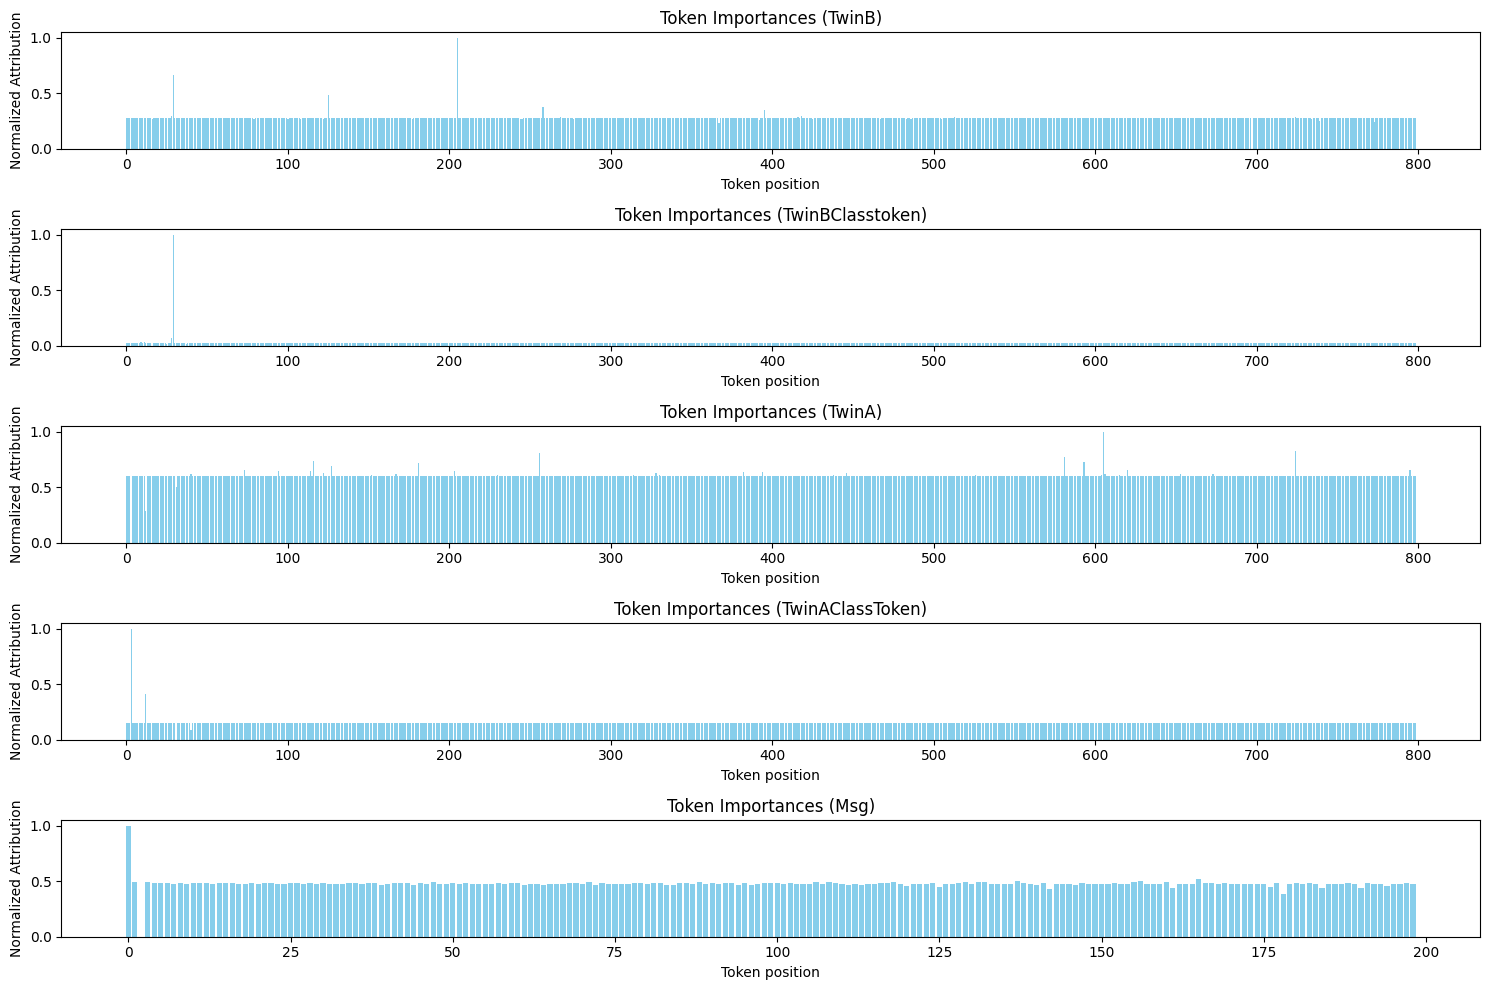

In [353]:
import matplotlib.pyplot as plt
import numpy as np

def plot_token_importances(token_importance, title, subplot_pos):
    norm_importance = (token_importance - token_importance.min()) / (token_importance.max() - token_importance.min())
    norm_importance = norm_importance.detach().cpu().numpy()

    plt.subplot(5, 1, subplot_pos)
    plt.bar(range(len(norm_importance)), norm_importance, color='skyblue')
    plt.xlabel("Token position")
    plt.ylabel("Normalized Attribution")
    plt.title(title)
    plt.tight_layout()

plt.figure(figsize=(15, 10))

plot_token_importances(token_importance_twinB, "Token Importances (TwinB)", 1)
plot_token_importances(token_importance_twinBCls, "Token Importances (TwinBClasstoken)", 2)
plot_token_importances(token_importance_twinA, "Token Importances (TwinA)", 3)
plot_token_importances(token_importance_twinACls, "Token Importances (TwinAClassToken)", 4)
plot_token_importances(token_importance_msg, "Token Importances (Msg)", 5)

plt.show()


In [354]:
xTwinB_ids

tensor([[ 10,  12,   2,  14, 102,   4,   9,  26,  15,   2,  22,   2,  14,   9,
           9,  26, 207,  56,  28,  21,  30,   2,  14,   9,  26, 207,  56,  37,
          21,  76,  17,  26, 207,  56,  39,  21, 231,  26,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0

In [355]:
len(xTwinB_ids_cls), len(attrTwinBCls)

(1, 1)

In [356]:
attrTwinBCls.shape

torch.Size([1, 799, 5])

In [357]:
# Assuming you have GetDiffDict and GetMsgDict defined and diffVocab, msgVocab loaded

def map_attributions_to_tokens(token_ids_tensor, attributions_tensor, decode_func, decdict):
    """
    Maps token IDs and attribution scores to (token, attribution) pairs for a single batch item.
    Args:
        token_ids_tensor: LongTensor of shape (batch_size, seq_len)
        attributions_tensor: FloatTensor of shape (batch_size, 1, seq_len, embedding_dim)
        decode_func: function that decodes list of token ids -> list of tokens (str)
    Returns:
        List of (token, attribution_score) tuples for batch item 0.
    """

    token_ids = token_ids_tensor[0].detach().cpu().tolist()  # seq_len
    attributions = attributions_tensor[0].squeeze(0).detach().cpu()  # (seq_len, embedding_dim)

    token_importances = attributions.sum(dim=1).tolist()

    tokens = decode_func(token_ids,decdict)

    token_attr_pairs = list(zip(tokens, token_importances))
    return token_attr_pairs


# Use your decode functions for each input part

twinb_token_attr = map_attributions_to_tokens(xTwinB_ids, attrTwinB, decode, diffDict)
twina_token_attr = map_attributions_to_tokens(xTwinA_ids, attrTwinA, decode, diffDict)
msg_token_attr = map_attributions_to_tokens(xMsg_ids, attrMsg, decodeMsg, msgDict)



In [358]:
def map_attributions_to_tokens_cls(token_ids_tensor, attributions_tensor):
    """
    Maps token IDs and attribution scores to (token, attribution) pairs for a single batch item.
    Args:
        token_ids_tensor: LongTensor of shape (batch_size, seq_len)
        attributions_tensor: FloatTensor of shape (batch_size, 1, seq_len, embedding_dim)
        decode_func: function that decodes list of token ids -> list of tokens (str)
    Returns:
        List of (token, attribution_score) tuples for batch item 0.
    """

    attributions = token_ids_tensor * attributions_tensor[0].squeeze(0).detach().cpu()  # (seq_len, embedding_dim)

    token_importances = attributions.sum(dim=2)
    tokens = np.array([classToName(np.argmax(tk)+1) for tk in token_ids_tensor[0]])
    token_attr_pairs = list(zip(tokens, token_importances.squeeze(0)))
    return token_attr_pairs

twinb_cls_token_attr = map_attributions_to_tokens_cls(xTwinB_ids_cls, attrTwinBCls)
twina_cls_token_attr = map_attributions_to_tokens_cls(xTwinA_ids_cls, attrTwinACls)


In [359]:
def print_tokens_until_padding(token_attr_pairs, token_ids, name):
    # Find first index of padding token (id=0)
    try:
        pad_index = token_ids.index(0)
    except ValueError:
        pad_index = len(token_ids)  # no padding found, print all

    print(f"{name} tokens and importances (up to first padding):")
    for token, score in token_attr_pairs[:pad_index]:
        print(f"{token}\t{score:.4f}")
    print("\n")

def print_tokens_until_padding_cls(token_attr_pairs, token_ids, cls_ids, name):
    # Find first index of padding token (id=0)
    try:
        pad_index = token_ids.index(0)
    except ValueError:
        pad_index = len(token_ids)  # no padding found, print all

    print(f"{name} tokens and importances:")
    for idx, (token, score) in enumerate(token_attr_pairs):
        print(f"{decode([token_ids[idx]],diffDict)[0]} \t {classToName(np.argmax(cls_ids[0][idx])+1)} \t{score:.4f}")
    print("\n")

# Extract token ids as lists
twinb_ids = xTwinB_ids[0].detach().cpu().tolist()
twina_ids = xTwinA_ids[0].detach().cpu().tolist()
msg_ids = xMsg_ids[0].detach().cpu().tolist()

print_tokens_until_padding(twinb_token_attr, twinb_ids, "TwinB")
print_tokens_until_padding_cls(twinb_cls_token_attr, twinb_ids ,xTwinB_ids_cls, "TwinBCls")
print_tokens_until_padding(twina_token_attr, twina_ids, "TwinA")
print_tokens_until_padding_cls(twina_cls_token_attr, twina_ids, xTwinA_ids_cls, "TwinACls")
print_tokens_until_padding(msg_token_attr, msg_ids, "Msg")


TwinB tokens and importances (up to first padding):
{	-0.0000
FUNC0	-0.0000
(	0.0000
LITERAL	-0.0000
+	0.0000
VAR0	0.0000
)	-0.0000
;	0.0000
FUNC1	0.0000
(	0.0001
FUNC2	0.0000
(	0.0001
LITERAL	0.0000
)	-0.0000
)	0.0000
;	0.0000
this	-0.0008
->	-0.0000
VAR3	0.0000
=	0.0000
FUNC3	-0.0000
(	0.0000
LITERAL	-0.0000
)	-0.0000
;	0.0000
this	-0.0003
->	-0.0000
VAR4	0.0000
=	0.0038
-	0.0668
1	0.0000
;	0.0000
this	-0.0000
->	0.0000
VAR5	-0.0000
=	0.0001
0	-0.0000
;	0.0002


TwinBCls tokens and importances:
{ 	 Punctuation 	0.0000
FUNC0 	 Identifier 	-0.0000
( 	 Punctuation 	0.0000
LITERAL 	 Literal 	0.0000
+ 	 Punctuation 	0.0000
VAR0 	 Identifier 	0.0000
) 	 Punctuation 	0.0000
; 	 Punctuation 	0.0000
FUNC1 	 Identifier 	0.0000
( 	 Punctuation 	0.0000
FUNC2 	 Identifier 	0.0000
( 	 Punctuation 	0.0000
LITERAL 	 Literal 	-0.0000
) 	 Punctuation 	0.0000
) 	 Punctuation 	0.0000
; 	 Punctuation 	-0.0000
this 	 Keyword 	-0.0000
-> 	 Punctuation 	-0.0000
VAR3 	 Identifier 	0.0000
= 	 Punctuation 	0.0

In [360]:
xTwinB_ids_cls

tensor([[[0, 0, 0, 1, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0],
         ...,
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0]]])

In [361]:
from IPython.display import display, HTML
import numpy as np

def value_to_color(score, importance):
    """
    Use importance (-1 to 1) to control green/red intensity.
    Positive importance → white to green
    Negative importance → red to white
    """
    if importance > 0:
        green_intensity = int(255 * importance)
        r = 255 - green_intensity
        g = 255
        b = 255 - green_intensity
    else:
        red_intensity = int(255 * (-importance))
        r = 255
        g = 255 - red_intensity
        b = 255 - red_intensity

    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    return f"rgb({r},{g},{b})"

def display_horizontal_sections(twinb, twina, msg, big_title="Attribution Comparison",
                                mini_titles=["TwinB", "TwinA", "Msg"]):
    # Compute per-section max absolute score for normalization (-1 to 1)
    def get_importance_scores(seq):
        if not seq:
            return []
        scores = np.array([score for _, score in seq])
        max_abs = np.max(np.abs(scores)) or 1
        return (scores / max_abs).tolist()

    twinb_importance = get_importance_scores(twinb)
    twina_importance = get_importance_scores(twina)
    msg_importance = get_importance_scores(msg)

    pad_states = [{'shown': False, 'skip': 0} for _ in range(3)]

    def format_rows(seq, importance, pad_state):
        rows = ""
        for idx, ((token, score), imp) in enumerate(zip(seq, importance)):
            if token == "<pad>":
                if pad_state['shown']:
                    pad_state['skip'] += 1
                    continue
                else:
                    pad_state['shown'] = True
            color = value_to_color(score, imp)
            token_display = "&lt;pad&gt;" if token == "<pad>" else token
            rows += f"""
            <tr style="background-color:{color};">
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{idx}</td>
                <td style="padding:4px; border-bottom:1px solid #ddd;">{token_display}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{score:.4f}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{imp:.4f}</td>
            </tr>
            """
        if pad_state['skip'] > 0:
            rows += f"""
            <tr>
                <td colspan="4" style="padding:4px; font-style: italic; color:#666; text-align:center;">
                    ... {pad_state['skip']} more &lt;pad&gt; tokens omitted ...
                </td>
            </tr>
            """
        return rows

    def make_section_html(seq, importance, pad_state, mini_title):
        rows_html = format_rows(seq, importance, pad_state)
        html = f"""
        <div style="flex: 1; min-width: 220px; margin: 0 10px;">
            <h4 style="text-align:center; font-family: Arial, sans-serif;">{mini_title}</h4>
            <table style="width: 100%; border-collapse: collapse; font-family: Arial, sans-serif; font-size: 0.9em;">
                <thead>
                    <tr>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Position</th>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Token</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Gradients</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Importance</th>
                    </tr>
                </thead>
                <tbody>
                    {rows_html}
                </tbody>
            </table>
        </div>
        """
        return html

    sections_html = "".join([
        make_section_html(twinb, twinb_importance, pad_states[0], mini_titles[0]),
        make_section_html(twina, twina_importance, pad_states[1], mini_titles[1]),
        make_section_html(msg, msg_importance, pad_states[2], mini_titles[2])
    ])

    full_html = f"""
    <div style="font-family: Arial, sans-serif; margin-bottom: 1em;">
        <h2 style="text-align:center;">{big_title}</h2>
        <div style="display: flex; justify-content: space-between; align-items: flex-start;">
            {sections_html}
        </div>
    </div>
    """

    display(HTML(full_html))
    return full_html

# Example usage:
# display_horizontal_sections(
#     twinb_token_attr, twina_token_attr, msg_token_attr,
#     big_title="SHAP Attribution Comparison",
#     mini_titles=["TwinB Tokens", "TwinA Tokens", "Message Tokens"]
# )

ig_fhtml = display_horizontal_sections(twinb_token_attr,twina_token_attr,msg_token_attr,big_title=f"Integrated Gradients | Sample {analyzedSampleIdx+1} CMP | (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})",mini_titles=["CBP Sequence", "CAP Sequence", "CMP Sequence"])



Position,Token,Gradients,Importance
0,{,-0.0000,-0.0000
1,FUNC0,-0.0000,-0.0000
2,(,0.0000,0.0001
3,LITERAL,-0.0000,-0.0000
4,+,0.0000,0.0000
5,VAR0,0.0000,0.0000
6,),-0.0000,-0.0000
7,;,0.0000,0.0002
8,FUNC1,0.0000,0.0000
9,(,0.0001,0.0007


In [362]:
import imgkit
!mkdir tmp

options = {
    "format": "png",
    "width": 1200,          # force the image width
    "disable-smart-width": "",
    "encoding": "utf-8",
    "quiet": ""
}

# Save your HTML string to a file
with open("tmp/ig.html", "w") as f:
    f.write(ig_fhtml)

# Convert saved HTML file to PNG
imgkit.from_file("tmp/ig.html", "plots/ig.png",options=options)


mkdir: cannot create directory ‘tmp’: File exists


True

In [363]:
from IPython.display import display, HTML
import numpy as np

def value_to_color(score, importance):
    """
    Use importance (-1 to 1) to control green/red intensity.
    Positive importance → white to green
    Negative importance → red to white
    """
    if importance > 0:
        green_intensity = int(255 * importance)
        r = 255 - green_intensity
        g = 255
        b = 255 - green_intensity
    else:
        red_intensity = int(255 * (-importance))
        r = 255
        g = 255 - red_intensity
        b = 255 - red_intensity

    r = max(0, min(255, r))
    g = max(0, min(255, g))
    b = max(0, min(255, b))
    return f"rgb({r},{g},{b})"

def display_horizontal_sections(twinb, twinbcls, twina, twinacls, msg, big_title="Attribution Comparison",
                                mini_titles=["TwinB", "TwinA", "Msg"]):
    # Compute per-section max absolute score for normalization (-1 to 1)
    def get_importance_scores(seq):
        if not seq:
            return []
        scores = np.array([score for _, score in seq])
        max_abs = np.max(np.abs(scores)) or 1
        return (scores / max_abs).tolist()

    def get_importance_scores_cls(seq):
        if not seq:
            return []
        scores = np.array([score for _, score in seq])
        max_abs = np.max(np.abs(scores)) or 1
        r = (scores / max_abs).tolist()
        return list(zip(seq,r))

    twinb_importance = get_importance_scores(twinb)
    twinb_importance_cls = get_importance_scores_cls(twinbcls)
    twina_importance = get_importance_scores(twina)
    twina_importance_cls = get_importance_scores_cls(twinacls)
    msg_importance = get_importance_scores(msg)

    pad_states = [{'shown': False, 'skip': 0} for _ in range(3)]

    def format_rows(seq, importance, pad_state):
        rows = ""
        for idx, ((token, score), imp) in enumerate(zip(seq, importance)):
            if token == "<pad>":
                if pad_state['shown']:
                    pad_state['skip'] += 1
                    continue
                else:
                    pad_state['shown'] = True
            color = value_to_color(score, imp)
            token_display = "&lt;pad&gt;" if token == "<pad>" else token
            rows += f"""
            <tr style="background-color:{color};">
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{idx}</td>
                <td style="padding:4px; border-bottom:1px solid #ddd;">{token_display}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{score:.4f}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{imp:.4f}</td>
            </tr>
            """
        if pad_state['skip'] > 0:
            rows += f"""
            <tr>
                <td colspan="4" style="padding:4px; font-style: italic; color:#666; text-align:center;">
                    ... {pad_state['skip']} more &lt;pad&gt; tokens omitted ...
                </td>
            </tr>
            """
        return rows

    def format_rows_cls(seq, importance, pad_state, importance_cls):
        rows = ""
        for idx, ((token, score), imp) in enumerate(zip(seq, importance)):
            if token == "<pad>":
                if pad_state['shown']:
                    pad_state['skip'] += 1
                    continue
                else:
                    pad_state['shown'] = True
            color = value_to_color(score, imp)
            token_display = "&lt;pad&gt;" if token == "<pad>" else token
            color_cls = value_to_color(None, importance_cls[idx][1])
            rows += f"""
            <tr style="background-color:{color};">
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{idx}</td>
                <td style="padding:4px; border-bottom:1px solid #ddd;">{token_display}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{score:.4f}</td>
                <td style="padding:4px; text-align:right; border-bottom:1px solid #ddd;">{imp:.4f}</td>
                <td style="padding:4px; text-align:right; background-color: {color_cls}; border-bottom:1px solid #ddd;">{importance_cls[idx][0][0]}</td>
                <td style="padding:4px; text-align:right; background-color: {color_cls}; border-bottom:1px solid #ddd;">{importance_cls[idx][0][1]:.4f}</td>
                <td style="padding:4px; text-align:right; background-color: {color_cls}; border-bottom:1px solid #ddd;">{importance_cls[idx][1]:.4f}</td>
            </tr>
            """
        if pad_state['skip'] > 0:
            rows += f"""
            <tr>
                <td colspan="4" style="padding:4px; font-style: italic; color:#666; text-align:center;">
                    ... {pad_state['skip']} more &lt;pad&gt; tokens omitted ...
                </td>
            </tr>
            """
        return rows

    def make_section_html_cls(seq, importance, pad_state, mini_title, importance_cls):
        rows_html = format_rows_cls(seq, importance, pad_state, importance_cls)
        html = f"""
        <div style="flex: 1; min-width: 600px; margin: 0 10px;">
            <h4 style="text-align:center; font-family: Arial, sans-serif;">{mini_title}</h4>
            <table style="width: 100%; border-collapse: collapse; font-family: Arial, sans-serif; font-size: 0.9em;">
                <thead>
                    <tr>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Position</th>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Token</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Gradients</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Importance</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Class</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Gradient(Class)</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Importance(Class)</th>
                    </tr>
                </thead>
                <tbody>
                    {rows_html}
                </tbody>
            </table>
        </div>
        """
        return html

    def make_section_html(seq, importance, pad_state, mini_title):
        rows_html = format_rows(seq, importance, pad_state)
        html = f"""
        <div style="flex: 1; min-width: 200px; margin: 0 10px;">
            <h4 style="text-align:center; font-family: Arial, sans-serif;">{mini_title}</h4>
            <table style="width: 100%; border-collapse: collapse; font-family: Arial, sans-serif; font-size: 0.9em;">
                <thead>
                    <tr>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Position</th>
                        <th style="text-align:left; padding:6px; border-bottom: 2px solid #444;">Token</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Gradients</th>
                        <th style="text-align:right; padding:6px; border-bottom: 2px solid #444;">Importance</th>
                    </tr>
                </thead>
                <tbody>
                    {rows_html}
                </tbody>
            </table>
        </div>
        """
        return html
    print(twina_importance_cls)
    sections_html = "".join([
        make_section_html_cls(twinb, twinb_importance, pad_states[0], mini_titles[0],twinb_importance_cls),
        make_section_html_cls(twina, twina_importance, pad_states[1], mini_titles[1],twina_importance_cls),
        make_section_html(msg, msg_importance, pad_states[2], mini_titles[2])
    ])

    full_html = f"""
    <div style="font-family: Arial, sans-serif; margin-bottom: 1em;">
        <h2 style="text-align:center;">{big_title}</h2>
        <div style="display: flex; justify-content: space-between; align-items: flex-start;">
            {sections_html}
        </div>
    </div>
    """

    display(HTML(full_html))
    return full_html

# Example usage:
# display_horizontal_sections(
#     twinb_token_attr, twina_token_attr, msg_token_attr,
#     big_title="SHAP Attribution Comparison",
#     mini_titles=["TwinB Tokens", "TwinA Tokens", "Message Tokens"]
# )

ig_fhtml = display_horizontal_sections(twinb_token_attr, twinb_cls_token_attr ,twina_token_attr, twinb_cls_token_attr, msg_token_attr,big_title=f"Integrated Gradients | Sample {analyzedSampleIdx+1} CMP | (Real:{eXlabel}, Predicted: {torch.argmax(model(torch.tensor(eX).unsqueeze(0)))})",mini_titles=["CBP Sequence", "CAP Sequence", "CMP Sequence"])



[(('Punctuation', tensor(2.4819e-08)), 1.5023904779809527e-05), (('Identifier', tensor(-1.0334e-07)), -6.255586049519479e-05), (('Punctuation', tensor(3.2382e-07)), 0.00019602272368501872), (('Literal', tensor(1.9079e-08)), 1.1549243026820477e-05), (('Punctuation', tensor(2.5258e-10)), 1.5289390375983203e-07), (('Identifier', tensor(1.4843e-06)), 0.0008985289023257792), (('Punctuation', tensor(3.5783e-10)), 2.166091945809967e-07), (('Punctuation', tensor(1.4065e-06)), 0.0008514174842275679), (('Identifier', tensor(1.1251e-06)), 0.0006810480845160782), (('Punctuation', tensor(1.3735e-05)), 0.008314463309943676), (('Identifier', tensor(3.1791e-09)), 1.924444632095401e-06), (('Punctuation', tensor(2.2699e-05)), 0.013740455731749535), (('Literal', tensor(-3.0193e-09)), -1.8276939499628497e-06), (('Punctuation', tensor(1.3727e-07)), 8.309644181281328e-05), (('Punctuation', tensor(1.0468e-10)), 6.336814806218172e-08), (('Punctuation', tensor(-2.2028e-09)), -1.333414729742799e-06), (('Keyword

Position,Token,Gradients,Importance,Class,Gradient(Class),Importance(Class)
0,{,-0.0000,-0.0000,Punctuation,0.0000,0.0000
1,FUNC0,-0.0000,-0.0000,Identifier,-0.0000,-0.0001
2,(,0.0000,0.0001,Punctuation,0.0000,0.0002
3,LITERAL,-0.0000,-0.0000,Literal,0.0000,0.0000
4,+,0.0000,0.0000,Punctuation,0.0000,0.0000
5,VAR0,0.0000,0.0000,Identifier,0.0000,0.0009
6,),-0.0000,-0.0000,Punctuation,0.0000,0.0000
7,;,0.0000,0.0002,Punctuation,0.0000,0.0009
8,FUNC1,0.0000,0.0000,Identifier,0.0000,0.0007
9,(,0.0001,0.0007,Punctuation,0.0000,0.0083


In [364]:
import imgkit
!mkdir tmp

options = {
    "format": "png",
    "width": 2500,          # force the image width
    "disable-smart-width": "",
    "encoding": "utf-8",
    "quiet": ""
}

# Save your HTML string to a file
with open("tmp/igv2.html", "w") as f:
    f.write(ig_fhtml)

# Convert saved HTML file to PNG
imgkit.from_file("tmp/igv2.html", "plots/igv2.png",options=options)


mkdir: cannot create directory ‘tmp’: File exists


True